# DigiCow Farmer Training Adoption Challenge

## 1 Introduction

### 1.1 Aim: 
To predict which farmers will turn training into action

### 1.2 Problem Statement:
Access to high-quality agricultural training is just the first step toward improving productivity of farms. However, understanding which farmers adopt improved practices after training and why is a real challenge.

### 1.3 Business Understanding: 
DigiCow supports smallholder farmers through digital tools, extension services, and targetted training programmes. However, like many real-world interventions, adoption rates remain low and uneven. The ability to predict adoption early can enable DigiCow and its partners to prioritise follow-ups, tailor support more effectively, and design stronger extension strategies. 

### 1.4 Project Pitch: 
Predict the probability that a farmer will adopt a practice within 120 days of their first training, only using information available at the time of training. So the trained model must output predicted probabilities indicating the likelihood that a farmer will adopt a DigiCow-supported practice within the target time window (120 days of their first training). 

In [1]:
# Imports
import pandas as pd
import numpy as np
from collections import Counter
import ast
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, RocCurveDisplay

# from catboost import CatBoostClassifier
# from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings('ignore')

## 2 Dataset Overview

### 2.1 Data Loading

In [2]:
# Load datasets
train_df = pd.read_csv('data/Train.csv')
test_df = pd.read_csv('data/Test.csv')
sample_sub = pd.read_csv('data/SampleSubmission.csv')
description = pd.read_csv('data/dataset_data_dictionary.csv')

In [3]:
description

,column_name,description
0,ID,unique identifier for each farmer entry
1,gender,Gender of the farmer
2,age,Age category of the farmer
3,registration,Registration method
4,belong_to_cooperative,Whether the farmer belongs to a cooperative (1...
5,county,County of residence
6,subcounty,Sub-county of residence
7,ward,Ward of residence
8,trainer,Trainer who delivered the first training
9,topics_list,List of possible training topics


In [4]:
sample_sub.head(2)

,ID,Target_AUC,Target_LogLoss
0,ID_KYO5JS,0,0
1,ID_846C1K,0,0


In [5]:
train_df.head(2)

,ID,gender,age,registration,belong_to_cooperative,county,subcounty,ward,trainer,first_training_date,topics_list,num_trainings_30d,num_trainings_60d,num_total_trainings,num_repeat_trainings,days_to_second_training,num_unique_trainers,adopted_within_120_days,has_second_training
0,ID_QB363K,Female,Above 35,Ussd,1,Siaya,Alego Usonga,South East Alego,trainer_name_5,2024-07-07,"['Biosecurity In Poultry Farming,Calf Feeding,...",1,1,1,0,NaN,1,0,0
1,ID_J75OZ4,Female,Below 35,Ussd,0,Nandi,Chesumei,Lelmokwo Ngechek,trainer_name_3,2024-07-26,"['Calf Feeding,How To Rear A Calf With Unga Pr...",1,1,1,0,NaN,1,0,0


In [6]:
test_df.head(2)

,ID,gender,age,registration,belong_to_cooperative,county,subcounty,ward,trainer,first_training_date,topics_list,num_trainings_30d,num_trainings_60d,num_total_trainings,num_repeat_trainings,days_to_second_training,num_unique_trainers,has_second_training
0,ID_KYO5JS,Female,Below 35,Ussd,0,Siaya,Alego Usonga,West Alego,trainer_name_5,2024-07-10,"['Biosecurity In Poultry Farming,Calf Feeding,...",1.0,1.0,1,0,NaN,1,0
1,ID_846C1K,Male,Below 35,Ussd,0,Bungoma,Kanduyi,Musikoma,trainer_name_2,2024-07-20,"['Herd Health Management.,Poultry Health Manag...",1.0,1.0,1,0,NaN,1,0


### 2.2 Target Variable Analysis
- Based on the description df; the target variable is `adopted_within_120_days`.
- Perform high-level overview of the training and test datasets to investigate their respective structure and access readiness for modelling. 

In [7]:
# High-level datasets overview
print(f"\nTrain Dataset Shape: {train_df.shape}")
print(f"Test Dataset Shape: {test_df.shape}")
print(f"\nNumber of Features in Train: {train_df.shape[1]}")
print(f"Number of Features in Test: {test_df.shape[1]}")

# Check for target variable
if 'adopted_within_120_days' in train_df.columns and 'adopted_within_120_days' not in test_df.columns:
    print(f"\nTarget variable 'adopted_within_120_days' found in train set")
    print(f"Target variable absent from test set")
else:
    print("\n Check target variable presence!")


Train Dataset Shape: (11780, 19)
Test Dataset Shape: (5055, 18)

Number of Features in Train: 19
Number of Features in Test: 18

Target variable 'adopted_within_120_days' found in train set
Target variable absent from test set


In [8]:
# rename `adopted_within_120_days` to `target`
train_df = train_df.rename(columns={'adopted_within_120_days': 'target'})
train_df['target'] = train_df['target'].astype('object')

- Investigate distribuction of the target variable and examine potential class imbalance. According to Xiao et al. (2024), a categorical target variable's scope of class imbalance is a crucial determinant factor for appropriate modelling strategies. 


Target Distribution:
target
0    11485
1      295
Name: count, dtype: int64

Target Proportions:
target
0    0.974958
1    0.025042
Name: proportion, dtype: float64


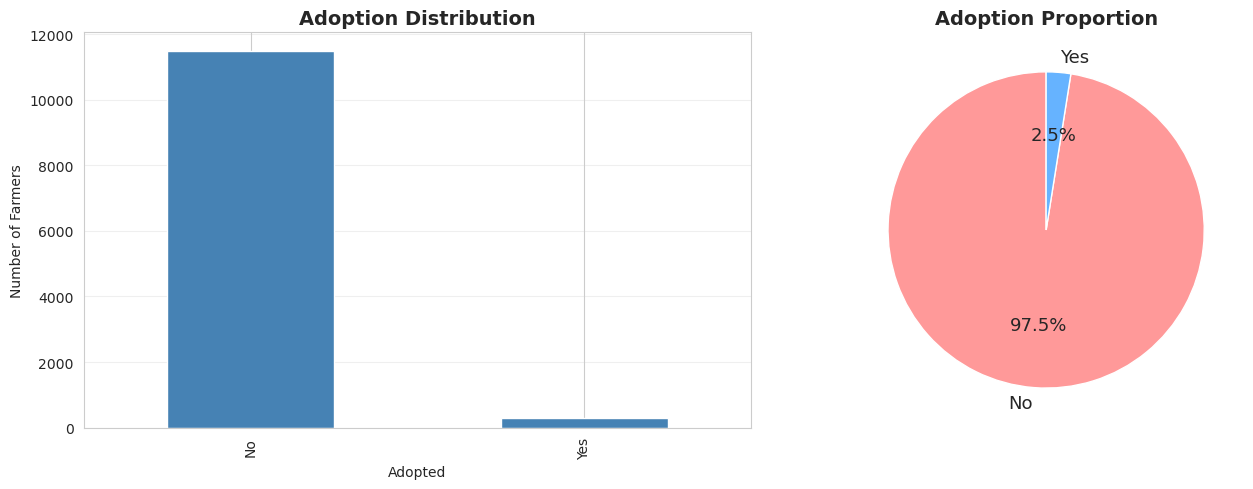


Class imbalance detected! Ratio: 38.93:1


In [9]:
# Target variable analysis
if 'target' in train_df.columns:
    print("\nTarget Distribution:")
    print(train_df['target'].value_counts().sort_index())
    print(f"\nTarget Proportions:")
    print(train_df['target'].value_counts(normalize=True).sort_index())
    
    # Create a mapping for target variable binary labels
    target_labels = {0: 'No', 1: 'Yes'}
    
    # Visualize target distribution
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Count plot with renamed labels
    counts = train_df['target'].value_counts().sort_index()
    counts.index = counts.index.map(target_labels)          
    counts.plot(kind='bar', ax=axes[0], color='steelblue')
    axes[0].set_title('Adoption Distribution', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Adopted')
    axes[0].set_ylabel('Number of Farmers')
    axes[0].grid(axis='y', alpha=0.3)
    
    # Pie chart with renamed labels
    target_counts = train_df['target'].value_counts().sort_index()
    target_counts.index = target_counts.index.map(target_labels) 
    axes[1].pie(target_counts, 
                 labels=target_counts.index,
                 autopct='%1.1f%%',
                 startangle=90,
                 colors=['#ff9999', '#66b3ff'],
                 textprops={'fontsize': 13})
    axes[1].set_title('Adoption Proportion', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Check for class imbalance 
    class_ratio = train_df['target'].value_counts().max() / train_df['target'].value_counts().min()
    if class_ratio > 1.5:
        print(f"\nClass imbalance detected! Ratio: {class_ratio:.2f}:1")
    else:
        print(f"\nClasses are relatively balanced. Ratio: {class_ratio:.2f}:1")

### 2.2 Basic Dataset Information

In [10]:
# Print 

print("\nTraining Dataset Information")
print(train_df.info())

print("\nTest Dataset Information")
print(test_df.info())


Training Dataset Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11780 entries, 0 to 11779
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       11780 non-null  object 
 1   gender                   11780 non-null  object 
 2   age                      11780 non-null  object 
 3   registration             11780 non-null  object 
 4   belong_to_cooperative    11780 non-null  int64  
 5   county                   11780 non-null  object 
 6   subcounty                11780 non-null  object 
 7   ward                     11780 non-null  object 
 8   trainer                  11780 non-null  object 
 9   first_training_date      11780 non-null  object 
 10  topics_list              11780 non-null  object 
 11  num_trainings_30d        11780 non-null  int64  
 12  num_trainings_60d        11780 non-null  int64  
 13  num_total_trainings      11780 non-null  int64

In [11]:
# Convert 'first_training_date' to datetime format
train_df['first_training_date'] = pd.to_datetime(train_df['first_training_date'])
test_df['first_training_date'] = pd.to_datetime(test_df['first_training_date'])

### 2.3 Missing Values Analysis


TRAIN SET - Columns with Missing Values:
                 Column  Missing_Count  Percentage
days_to_second_training          11667   99.040747


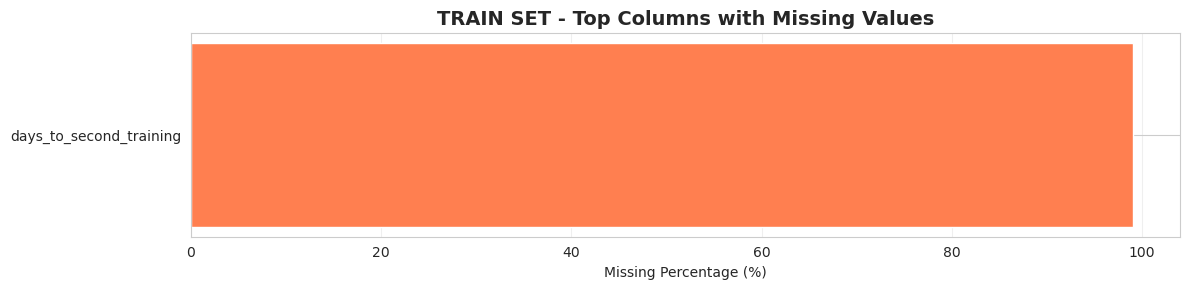


TEST SET - Columns with Missing Values:
                 Column  Missing_Count  Percentage
days_to_second_training           5007   99.050445


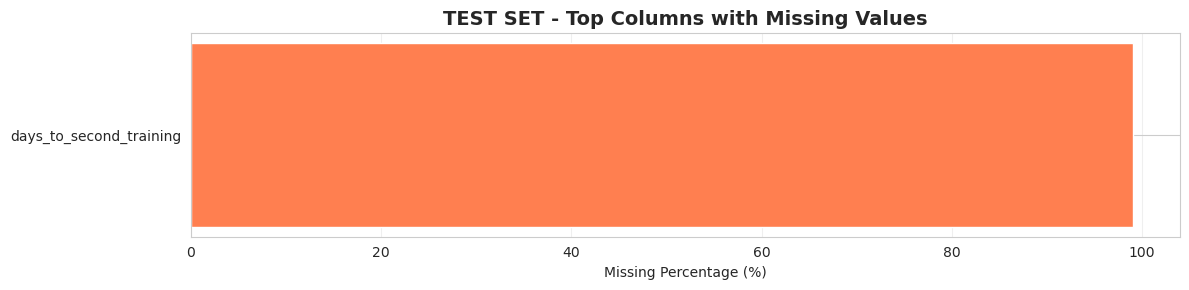

In [12]:
# Missing values check
def analyze_missing(df, name):
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    missing_df = pd.DataFrame({
        'Column': missing.index,
        'Missing_Count': missing.values,
        'Percentage': missing_pct.values
    }).query('Missing_Count > 0').sort_values('Percentage', ascending=False)

    print(f"\n{name} - Columns with Missing Values:")
    if len(missing_df) > 0:
        print(missing_df.to_string(index=False))

        # Visualize top missing columns
        if len(missing_df) > 0:
            top_missing = missing_df.head(15)
            plt.figure(figsize=(12, 3))
            plt.barh(top_missing['Column'], top_missing['Percentage'], color='coral')
            plt.xlabel('Missing Percentage (%)')
            plt.title(f'{name} - Top Columns with Missing Values', fontsize=14, fontweight='bold')
            plt.gca().invert_yaxis()
            plt.grid(axis='x', alpha=0.3)
            plt.tight_layout()
            plt.show()
    else:
        print("No missing values found!")

    return missing_df

train_missing = analyze_missing(train_df, "TRAIN SET")
test_missing = analyze_missing(test_df, "TEST SET")

- Due to the high percentage of missing data for the `days_to_second_training` for both the training and test datasets; the feature is eliminated.

In [13]:
# Remove the column from both dataframes
columns_to_drop = ['days_to_second_training']

train_df = train_df.drop(columns=columns_to_drop, errors='ignore')
test_df   = test_df.drop(columns=columns_to_drop,   errors='ignore')

### 2.4 Numerical Features Analysis

- Examine the numerical features to understand their respective distribuction, scales, and summary statistics. According to Zhou et al.(2017), evaluating the distribuction of numerical features is critical for:
   1. Feature scalling and normalization.
   2. Outlier treatment.
   3. Informing appropriate modelling techniques. 

In [14]:
# Identify numerical columns
numerical_cols = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'target' in numerical_cols:
    numerical_cols.remove('target')

print("\nStatistical Summary:")
train_df[numerical_cols].describe()


Statistical Summary:


,belong_to_cooperative,num_trainings_30d,num_trainings_60d,num_total_trainings,num_repeat_trainings,num_unique_trainers,has_second_training
count,11780.000000,11780.000000,11780.000000,11780.000000,11780.000000,11780.0,11780.000000
mean,0.318676,1.013328,1.013328,1.013328,0.013328,1.0,0.009593
std,0.465983,0.151655,0.151655,0.151655,0.151655,0.0,0.097475
min,0.000000,1.000000,1.000000,1.000000,0.000000,1.0,0.000000
25%,0.000000,1.000000,1.000000,1.000000,0.000000,1.0,0.000000
50%,0.000000,1.000000,1.000000,1.000000,0.000000,1.0,0.000000
75%,1.000000,1.000000,1.000000,1.000000,0.000000,1.0,0.000000
max,1.000000,5.000000,5.000000,5.000000,4.000000,1.0,1.000000


In [15]:
# Examine respective value counts
features = ['belong_to_cooperative', 'num_trainings_30d', 'num_trainings_60d',
            'num_total_trainings', 'num_repeat_trainings', 'num_unique_trainers', 'has_second_training']

for col in features:
    print(f" Value Counts for: {col}")
    print(train_df[col].value_counts())
    print("\n") 

 Value Counts for: belong_to_cooperative
belong_to_cooperative
0    8026
1    3754
Name: count, dtype: int64


 Value Counts for: num_trainings_30d
num_trainings_30d
1    11667
2       80
3       25
4        5
5        3
Name: count, dtype: int64


 Value Counts for: num_trainings_60d
num_trainings_60d
1    11667
2       80
3       25
4        5
5        3
Name: count, dtype: int64


 Value Counts for: num_total_trainings
num_total_trainings
1    11667
2       80
3       25
4        5
5        3
Name: count, dtype: int64


 Value Counts for: num_repeat_trainings
num_repeat_trainings
0    11667
1       80
2       25
3        5
4        3
Name: count, dtype: int64


 Value Counts for: num_unique_trainers
num_unique_trainers
1    11780
Name: count, dtype: int64


 Value Counts for: has_second_training
has_second_training
0    11667
1      113
Name: count, dtype: int64




In [16]:
# Identify numerical columns
numerical_cols = test_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'target' in numerical_cols:
    numerical_cols.remove('target')

print("\nStatistical Summary:")
train_df[numerical_cols].describe()


Statistical Summary:


,belong_to_cooperative,num_trainings_30d,num_trainings_60d,num_total_trainings,num_repeat_trainings,num_unique_trainers,has_second_training
count,11780.000000,11780.000000,11780.000000,11780.000000,11780.000000,11780.0,11780.000000
mean,0.318676,1.013328,1.013328,1.013328,0.013328,1.0,0.009593
std,0.465983,0.151655,0.151655,0.151655,0.151655,0.0,0.097475
min,0.000000,1.000000,1.000000,1.000000,0.000000,1.0,0.000000
25%,0.000000,1.000000,1.000000,1.000000,0.000000,1.0,0.000000
50%,0.000000,1.000000,1.000000,1.000000,0.000000,1.0,0.000000
75%,1.000000,1.000000,1.000000,1.000000,0.000000,1.0,0.000000
max,1.000000,5.000000,5.000000,5.000000,4.000000,1.0,1.000000


In [17]:
# Examine respective value counts
features = ['belong_to_cooperative', 'num_trainings_30d', 'num_trainings_60d',
            'num_total_trainings', 'num_repeat_trainings', 'num_unique_trainers', 'has_second_training']

for col in features:
    print(f" Value Counts for: {col}")
    print(test_df[col].value_counts())
    print("\n") 

 Value Counts for: belong_to_cooperative
belong_to_cooperative
0    3420
1    1635
Name: count, dtype: int64


 Value Counts for: num_trainings_30d
num_trainings_30d
1.0    5007
2.0      32
3.0      11
4.0       4
6.0       1
Name: count, dtype: int64


 Value Counts for: num_trainings_60d
num_trainings_60d
1.0    5007
2.0      32
3.0      11
4.0       4
6.0       1
Name: count, dtype: int64


 Value Counts for: num_total_trainings
num_total_trainings
1    5007
2      32
3      11
4       4
6       1
Name: count, dtype: int64


 Value Counts for: num_repeat_trainings
num_repeat_trainings
0    5007
1      32
2      11
3       4
5       1
Name: count, dtype: int64


 Value Counts for: num_unique_trainers
num_unique_trainers
1    5055
Name: count, dtype: int64


 Value Counts for: has_second_training
has_second_training
0    5007
1      48
Name: count, dtype: int64




- It is evident that `belong_to_cooperative`, and `has_second_training` are indeed categorical in nature.
- The value_counts for `num_unique_trainers` reveals all rows are assigned to 1.

Thus, the numerical features are converted to object and `num_unique_trainers` removed from feature set. 

In [18]:
# Drop unwanted column
train_df.drop(columns='num_unique_trainers', errors='ignore', inplace=True)
test_df.drop(columns='num_unique_trainers',  errors='ignore', inplace=True)

# Convert to object (categorical-like treatment)
cols = [
    'belong_to_cooperative',
    'has_second_training'
]

for df in [train_df, test_df]:
    for col in cols:
        if col in df.columns:
            df[col] = df[col].astype('object')

In [19]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11780 entries, 0 to 11779
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ID                     11780 non-null  object        
 1   gender                 11780 non-null  object        
 2   age                    11780 non-null  object        
 3   registration           11780 non-null  object        
 4   belong_to_cooperative  11780 non-null  object        
 5   county                 11780 non-null  object        
 6   subcounty              11780 non-null  object        
 7   ward                   11780 non-null  object        
 8   trainer                11780 non-null  object        
 9   first_training_date    11780 non-null  datetime64[ns]
 10  topics_list            11780 non-null  object        
 11  num_trainings_30d      11780 non-null  int64         
 12  num_trainings_60d      11780 non-null  int64         
 13  n

In [20]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5055 entries, 0 to 5054
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ID                     5055 non-null   object        
 1   gender                 5055 non-null   object        
 2   age                    5055 non-null   object        
 3   registration           5055 non-null   object        
 4   belong_to_cooperative  5055 non-null   object        
 5   county                 5055 non-null   object        
 6   subcounty              5055 non-null   object        
 7   ward                   5055 non-null   object        
 8   trainer                5055 non-null   object        
 9   first_training_date    5055 non-null   datetime64[ns]
 10  topics_list            5055 non-null   object        
 11  num_trainings_30d      5055 non-null   float64       
 12  num_trainings_60d      5055 non-null   float64       
 13  num

### 2.5 Categorical Features Analysis

Examine the categorical features focusing on respective variety, and uniqueness to ensure that these variables are handled efficiently and appropriately during feature engineering and model training. 

Investing categorical features also facilitates: 

- **Cardinality Analysis :** For each categorical feature, the number of unique values is computed to examine respective cardinality. According to Nargesian et al. (2017), comprehending categorical cardinality is vital for guiding encoding strategy selection.
    1. Low Cardinality: One-hot encoding.
    2. High Cardinality: Target encoding, frequency encoding, or embedding-based approaches.


- **Overfitting Likelihood :** Examine categorical features that have a significant potential to cause overfitting or increase model complexity unncessarily. 

In [21]:
# Categorical features' anaysis

# Identify categorical columns
categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()
if 'ID' in categorical_cols:
    categorical_cols.remove('ID')

print(f"\nCategorical Features ({len(categorical_cols)}):")
print(categorical_cols)

# Cardinality analysis
print("\nCardinality (Unique Values) for Categorical Features (train_df):")
cardinality_df = pd.DataFrame({
    'Feature': categorical_cols,
    'Unique_Values': [train_df[col].nunique() for col in categorical_cols]
}).sort_values('Unique_Values', ascending=False)
print(cardinality_df.to_string(index=False))


Categorical Features (11):
['gender', 'age', 'registration', 'belong_to_cooperative', 'county', 'subcounty', 'ward', 'trainer', 'topics_list', 'target', 'has_second_training']

Cardinality (Unique Values) for Categorical Features (train_df):
              Feature  Unique_Values
          topics_list           2175
                 ward             51
            subcounty             17
               county              5
              trainer              5
               gender              2
                  age              2
         registration              2
belong_to_cooperative              2
               target              2
  has_second_training              2


In [22]:
# Categorical features' anaysis

# Identify categorical columns
categorical_cols = test_df.select_dtypes(include=['object']).columns.tolist()
if 'ID' in categorical_cols:
    categorical_cols.remove('ID')

print(f"\nCategorical Features ({len(categorical_cols)}):")
print(categorical_cols)

# Cardinality analysis
print("\nCardinality (Unique Values) for Categorical Features (test_df):")
cardinality_df = pd.DataFrame({
    'Feature': categorical_cols,
    'Unique_Values': [test_df[col].nunique() for col in categorical_cols]
}).sort_values('Unique_Values', ascending=False)
print(cardinality_df.to_string(index=False))


Categorical Features (10):
['gender', 'age', 'registration', 'belong_to_cooperative', 'county', 'subcounty', 'ward', 'trainer', 'topics_list', 'has_second_training']

Cardinality (Unique Values) for Categorical Features (test_df):
              Feature  Unique_Values
          topics_list           1222
                 ward             51
            subcounty             19
               county              5
              trainer              5
               gender              2
                  age              2
         registration              2
belong_to_cooperative              2
  has_second_training              2


| Feature                  | Unique Values | Cardinality Level     | Risk Level       |
|--------------------------|---------------|-----------------------|------------------|
| topics_list              | 2175          | Very High             | Very High        |
| ward                     | 51            | Medium-High           | Medium-High      |
| subcounty                | 17            | Medium                | Medium           |
| county                   | 5             | Low                   | Low              |
| trainer                  | 5             | Low                   | Low              |
| num_trainings_30d        | 5             | Low                   | Low              |
| num_trainings_60d        | 5             | Low                   | Low              |
| num_total_trainings      | 5             | Low                   | Low              |
| num_repeat_trainings     | 5             | Low                   | Low              |
| gender                   | 2             | Binary                | Low              |
| age                      | 2             | Binary                | Low              |
| registration             | 2             | Binary                | Low              |
| belong_to_cooperative    | 2             | Binary                | Low              |
| has_second_training      | 2             | Binary                | Low              |

#### 2.5.1 Examining `ward` feature

In [23]:
test_df['ward'].unique()

array(['West Alego', 'Musikoma', 'South East Alego', 'Ugunja', 'Kimaeti',
       'Siaya Township', 'Central Gem', 'South Gem', 'Lelmokwo Ngechek',
       'Central Alego', 'Ndalat', 'North Alego', 'Siboti', 'Kilibwoni',
       'Kabisaga', 'Bumula', 'Kosirai', 'Chemundu/Kapngetuny', 'Kabula',
       'Kabiyet', 'Sigomere', 'Bukembe East', 'Kaptel/Kamoiywo',
       'West Bukusu', 'Matisi', 'Sangalo Kebulonik', 'Kabuchai/Chwele',
       'East Gem', 'Simat Kapseret', 'Saboti', 'Mois Bridge', 'Kwanza',
       'South Bukusu', 'Bwake/Luuya', 'Kurgung/Surungai', 'Kinyoro',
       'Makutano', 'Yala Township', 'Township', 'Select Your Ward',
       'Marakaru/Tuuti', 'North Sakwa', 'East Asembo', 'Kipkaren',
       'North Ugenya', 'Bukembe West', 'Chepkunyuk', 'Chepterwai',
       'Khalaba', 'West Uyoma', 'West Sangalo'], dtype=object)

In [24]:
train_df['ward'].unique()

array(['South East Alego', 'Lelmokwo Ngechek', 'Kimaeti',
       'Siaya Township', 'Ndalat', 'Ugunja', 'West Alego', 'Musikoma',
       'Central Alego', 'Central Gem', 'North Alego', 'Kabisaga',
       'South Gem', 'Kabiyet', 'Siboti', 'Bumula', 'Sigomere', 'Kabula',
       'Kilibwoni', 'Kosirai', 'Bukembe East', 'Kaptel/Kamoiywo',
       'Chemundu/Kapngetuny', 'Yala Township', 'Sangalo Kebulonik',
       'Matisi', 'East Gem', 'Tuwani', 'Kabuchai/Chwele',
       'Simat Kapseret', 'Saboti', 'West Bukusu', 'Kwanza', 'Mois Bridge',
       'South Bukusu', 'Soy', 'Bwake/Luuya', 'Kinyoro',
       'Kurgung/Surungai', 'Township', 'Marakaru/Tuuti', 'Kipkaren',
       'Khalaba', 'East Asembo', 'North Ugenya', 'West Uyoma',
       'Bukembe West', 'Chepterwai', 'West Sangalo', 'North Sakwa',
       'Chepkunyuk'], dtype=object)

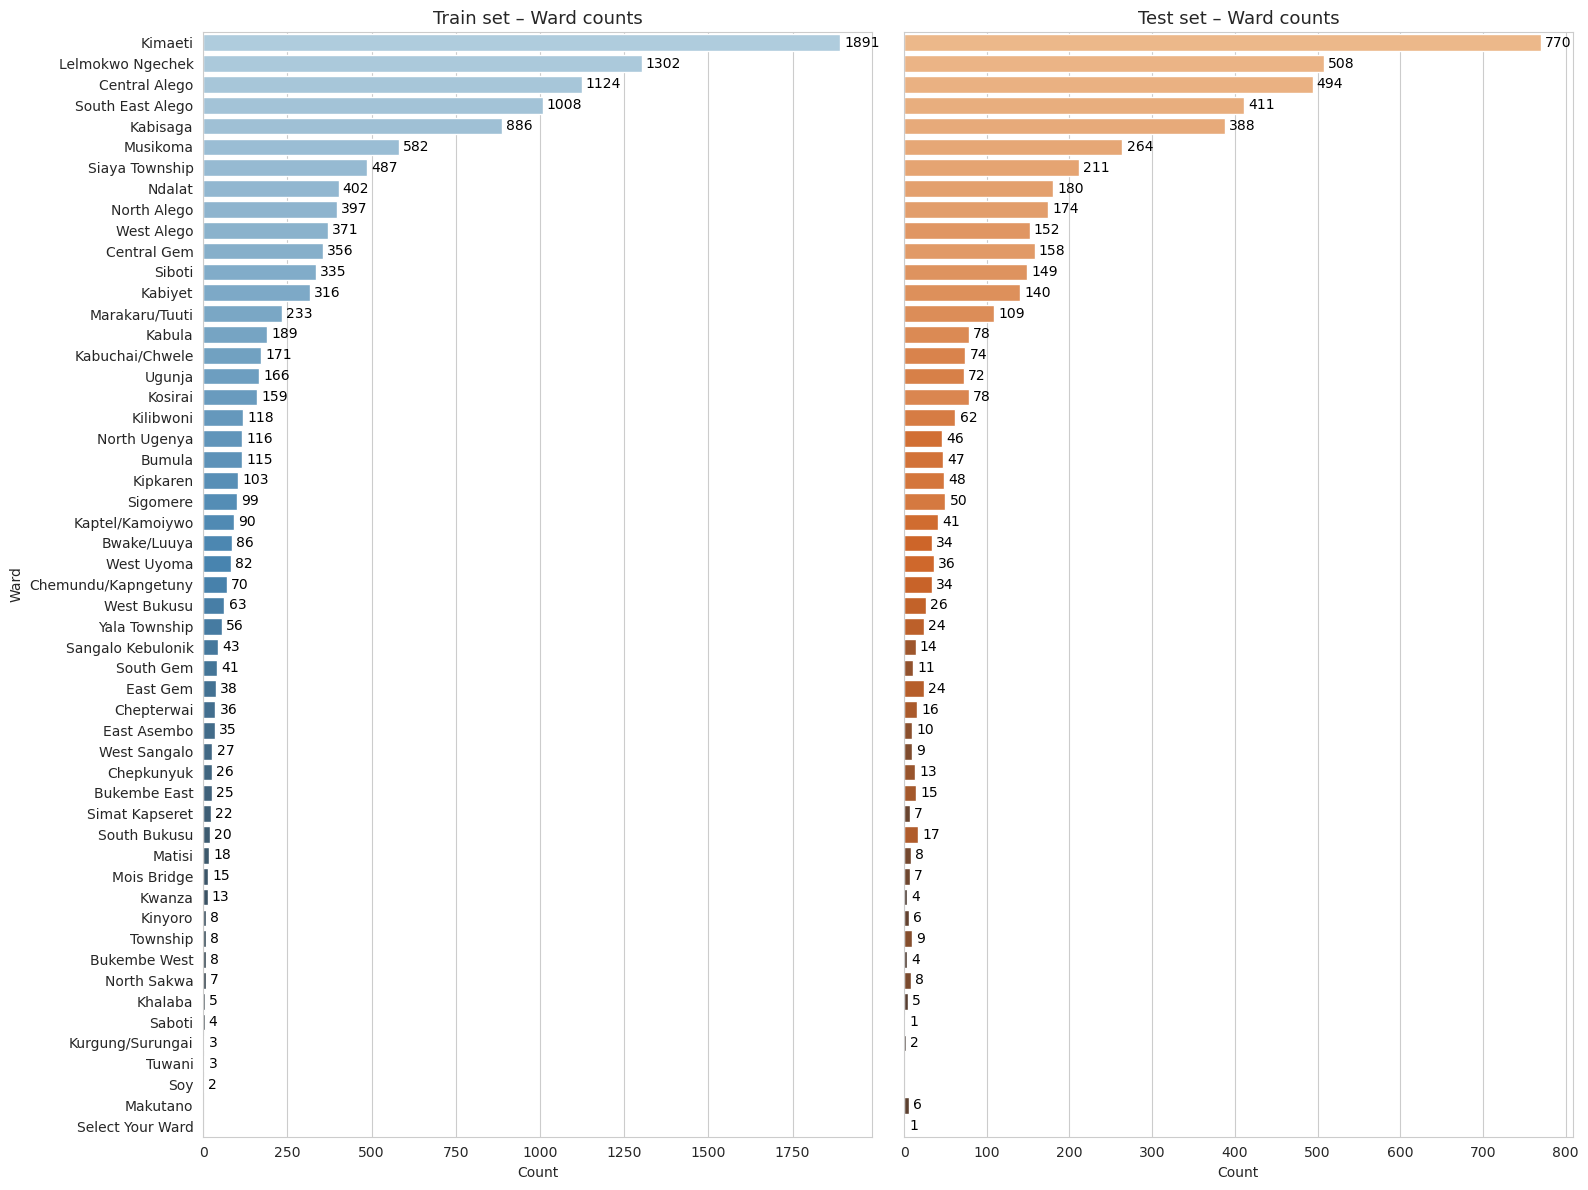

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(16, 12), sharey=True)

# Train
ax = axes[0]
sns.countplot(data=train_df, y='ward', order=train_df['ward'].value_counts().index, ax=axes[0], palette='Blues_d')
axes[0].set_title('Train set – Ward counts', fontsize=13)
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Ward')
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3, fontsize=10, color='black')

# Test
ax = axes[1]
sns.countplot(data=test_df, y='ward', order=test_df['ward'].value_counts().index, ax=axes[1], palette='Oranges_d')
axes[1].set_title('Test set – Ward counts', fontsize=13)
axes[1].set_xlabel('Count')
axes[1].set_ylabel('')
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3, fontsize=10, color='black')

plt.tight_layout()
plt.show()

#### 2.5.2 Examining `subcounty` feature

In [26]:
test_df['subcounty'].unique()

array(['Alego Usonga', 'Kanduyi', 'Ugunja', 'Bumula', 'Gem', 'Chesumei',
       'Mosop', 'Emgwen', 'Saboti', 'Kabuchai', 'Kapseret', 'Soy',
       'Kwanza', 'Cherangany', 'Select Your Sub County', 'Bondo',
       'Rarieda', 'Ugenya', 'Nandi Hills'], dtype=object)

In [27]:
train_df['subcounty'].unique()

array(['Alego Usonga', 'Chesumei', 'Bumula', 'Mosop', 'Ugunja', 'Kanduyi',
       'Gem', 'Emgwen', 'Saboti', 'Kabuchai', 'Kapseret', 'Kwanza', 'Soy',
       'Rarieda', 'Ugenya', 'Bondo', 'Nandi Hills'], dtype=object)

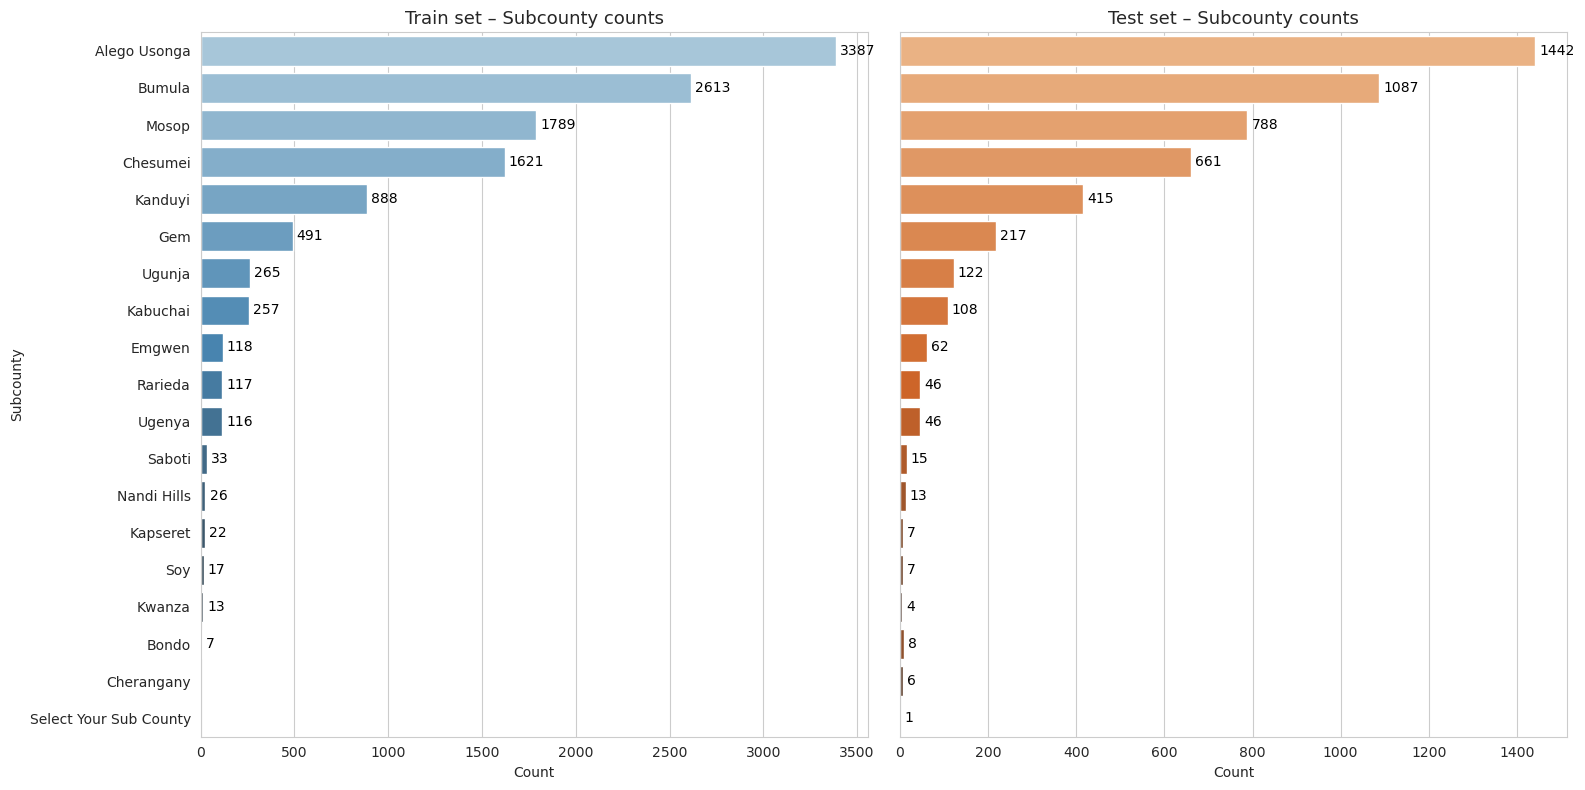

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# Train
ax = axes[0]
sns.countplot(data=train_df, y='subcounty', order=train_df['subcounty'].value_counts().index, ax=axes[0], palette='Blues_d')
axes[0].set_title('Train set – Subcounty counts', fontsize=13)
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Subcounty')
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3, fontsize=10, color='black')

# Test
ax = axes[1]
sns.countplot(data=test_df, y='subcounty', order=test_df['subcounty'].value_counts().index, ax=axes[1], palette='Oranges_d')
axes[1].set_title('Test set – Subcounty counts', fontsize=13)
axes[1].set_xlabel('Count')
axes[1].set_ylabel('')
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3, fontsize=10, color='black')
plt.tight_layout()
plt.show()

#### 2.5.3 Examining `county` feature

In [29]:
test_df['county'].unique()

array(['Siaya', 'Bungoma', 'Nandi', 'Trans Nzoia', 'Uasin Gishu'],
      dtype=object)

In [30]:
train_df['county'].unique()

array(['Siaya', 'Nandi', 'Bungoma', 'Trans Nzoia', 'Uasin Gishu'],
      dtype=object)

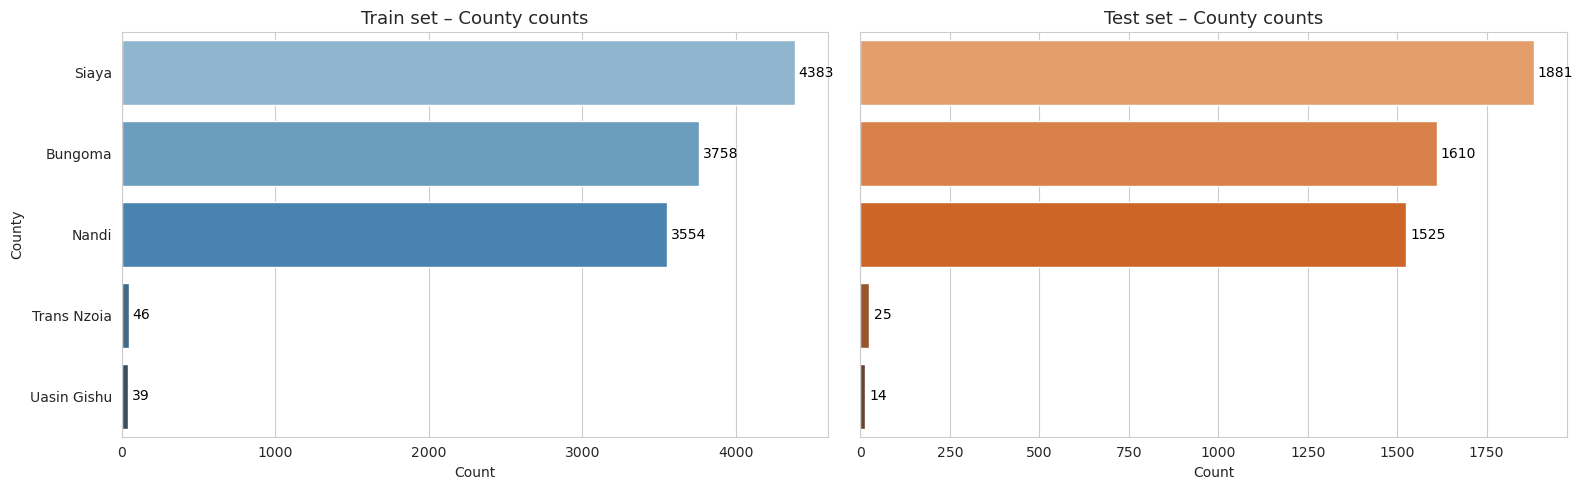

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

# Train
ax = axes[0]
sns.countplot(data=train_df, y='county', order=train_df['county'].value_counts().index, ax=axes[0], palette='Blues_d')
axes[0].set_title('Train set – County counts', fontsize=13)
axes[0].set_xlabel('Count')
axes[0].set_ylabel('County')
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3, fontsize=10, color='black')

# Test
ax = axes[1]
sns.countplot(data=test_df, y='county', order=test_df['county'].value_counts().index, ax=axes[1], palette='Oranges_d')
axes[1].set_title('Test set – County counts', fontsize=13)
axes[1].set_xlabel('Count')
axes[1].set_ylabel('')
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3, fontsize=10, color='black')
plt.tight_layout()
plt.show()

#### 2.5.4 Examining `trainer` feature

In [32]:
test_df['trainer'].unique()

array(['trainer_name_5', 'trainer_name_2', 'trainer_name_3',
       'trainer_name_4', 'Other'], dtype=object)

In [33]:
train_df['trainer'].unique()

array(['trainer_name_5', 'trainer_name_3', 'trainer_name_2',
       'trainer_name_4', 'Other'], dtype=object)

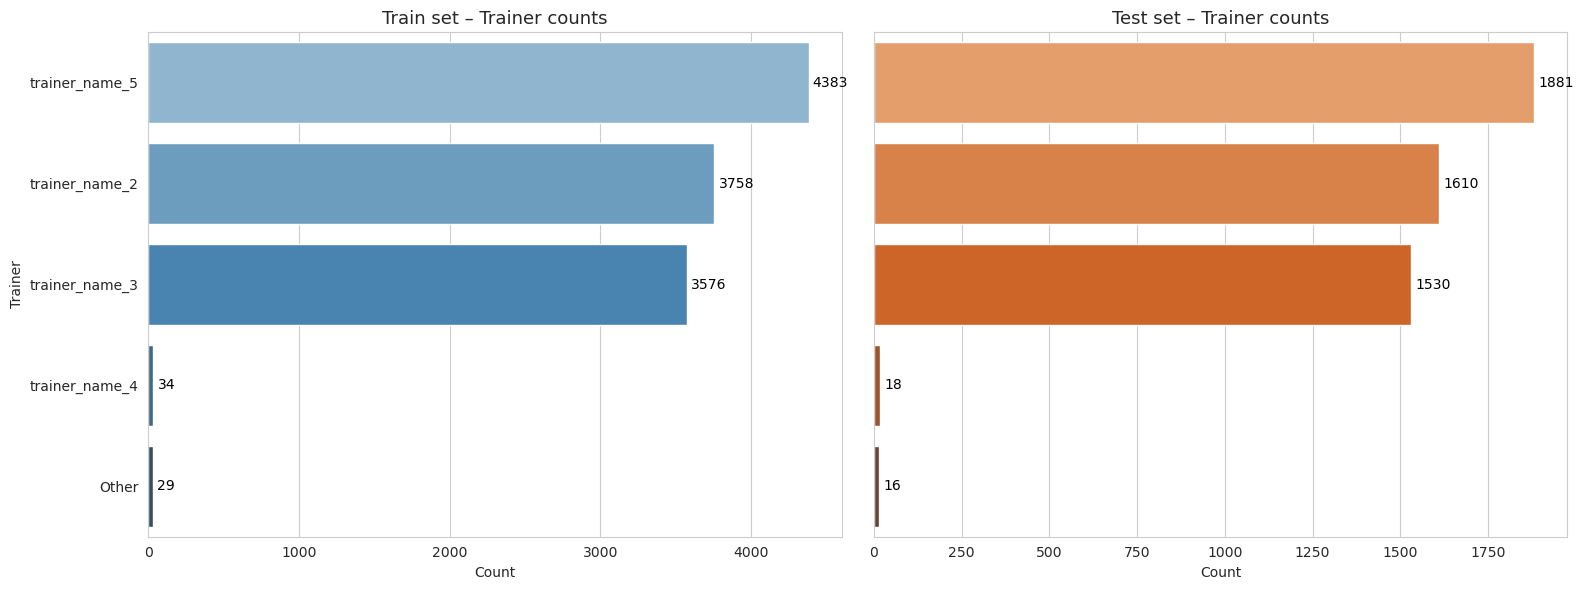

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Train
ax = axes[0]
sns.countplot(data=train_df, y='trainer', order=train_df['trainer'].value_counts().index, ax=axes[0], palette='Blues_d')
axes[0].set_title('Train set – Trainer counts', fontsize=13)
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Trainer')
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3, fontsize=10, color='black')

# Test
ax = axes[1]
sns.countplot(data=test_df, y='trainer', order=test_df['trainer'].value_counts().index, ax=axes[1], palette='Oranges_d')
axes[1].set_title('Test set – Trainer counts', fontsize=13)
axes[1].set_xlabel('Count')
axes[1].set_ylabel('')
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3, fontsize=10, color='black')
plt.tight_layout()
plt.show()

#### 2.5.5 Examining `gender` feature

In [35]:
test_df['gender'].unique()

array(['Female', 'Male'], dtype=object)

In [36]:
train_df['gender'].unique()

array(['Female', 'Male'], dtype=object)

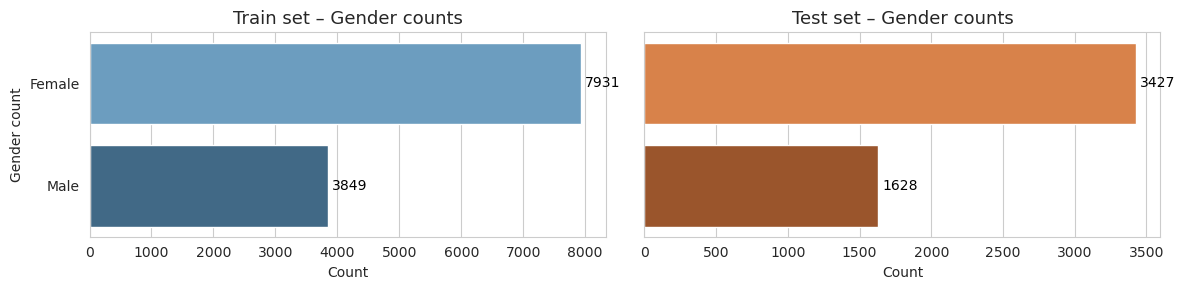

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3), sharey=True)

# Train
ax = axes[0]
sns.countplot(data=train_df, y='gender', order=train_df['gender'].value_counts().index, ax=axes[0], palette='Blues_d')
axes[0].set_title('Train set – Gender counts', fontsize=13)
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Gender count')
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3, fontsize=10, color='black')

# Test
ax = axes[1]
sns.countplot(data=test_df, y='gender', order=test_df['gender'].value_counts().index, ax=axes[1], palette='Oranges_d')
axes[1].set_title('Test set – Gender counts', fontsize=13)
axes[1].set_xlabel('Count')
axes[1].set_ylabel('')
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3, fontsize=10, color='black')
plt.tight_layout()
plt.show()

#### 2.5.6 Examining `age` feature

In [38]:
test_df['age'].unique()

array(['Below 35', 'Above 35'], dtype=object)

In [39]:
train_df['age'].unique()

array(['Above 35', 'Below 35'], dtype=object)

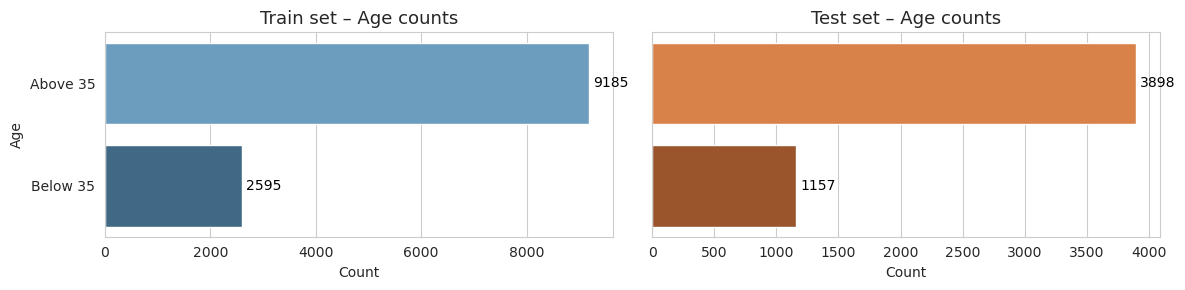

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3), sharey=True)

# Train
ax = axes[0]
sns.countplot(data=train_df, y='age', order=train_df['age'].value_counts().index, ax=axes[0], palette='Blues_d')
axes[0].set_title('Train set – Age counts', fontsize=13)
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Age')
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3, fontsize=10, color='black')

# Test
ax = axes[1]
sns.countplot(data=test_df, y='age', order=test_df['age'].value_counts().index, ax=axes[1], palette='Oranges_d')
axes[1].set_title('Test set – Age counts', fontsize=13)
axes[1].set_xlabel('Count')
axes[1].set_ylabel('')
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3, fontsize=10, color='black')
plt.tight_layout()
plt.show()

#### 2.5.7 Examining `registration` feature

In [41]:
test_df['registration'].unique()

array(['Ussd', 'Manual'], dtype=object)

In [42]:
train_df['registration'].unique()

array(['Ussd', 'Manual'], dtype=object)

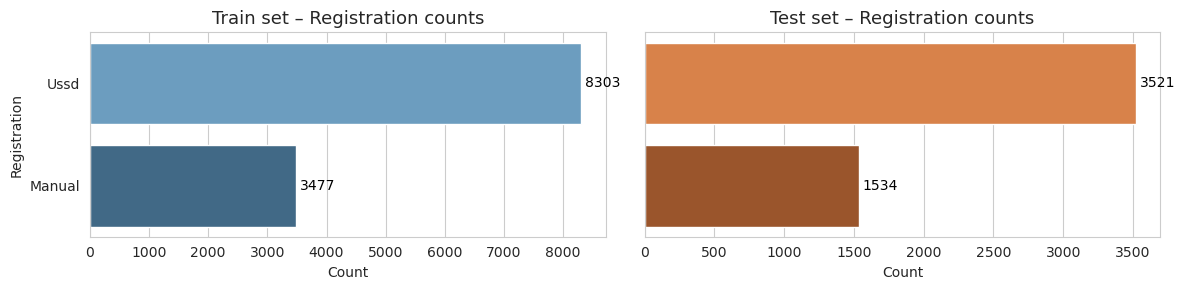

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3), sharey=True)

# Train
ax = axes[0]
sns.countplot(data=train_df, y='registration', order=train_df['registration'].value_counts().index, ax=axes[0], palette='Blues_d')
axes[0].set_title('Train set – Registration counts', fontsize=13)
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Registration')
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3, fontsize=10, color='black')

# Test
ax = axes[1]
sns.countplot(data=test_df, y='registration', order=test_df['registration'].value_counts().index, ax=axes[1], palette='Oranges_d')
axes[1].set_title('Test set – Registration counts', fontsize=13)
axes[1].set_xlabel('Count')
axes[1].set_ylabel('')
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3, fontsize=10, color='black')
plt.tight_layout()
plt.show()

#### 2.5.8 Examining `belong_to_cooperative` feature

In [44]:
test_df['belong_to_cooperative'].unique()

array([0, 1], dtype=object)

In [45]:
train_df['belong_to_cooperative'].unique()

array([1, 0], dtype=object)

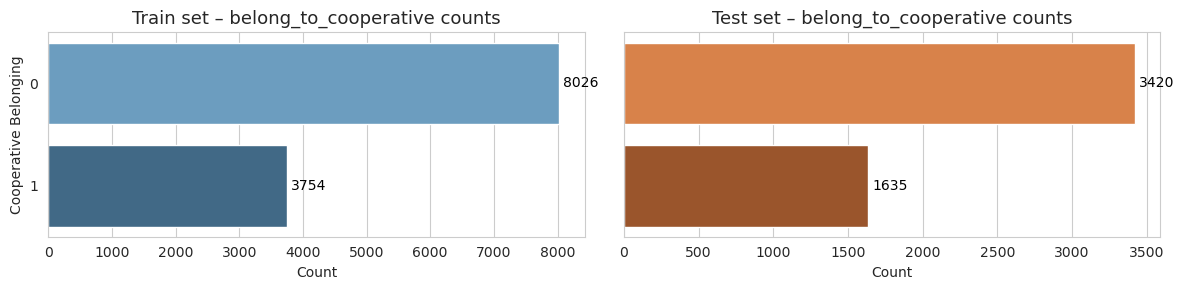

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3), sharey=True)

# Train
ax = axes[0]
sns.countplot(data=train_df, y='belong_to_cooperative', order=train_df['belong_to_cooperative'].value_counts().index, ax=axes[0], palette='Blues_d')
axes[0].set_title('Train set – belong_to_cooperative counts', fontsize=13)
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Cooperative Belonging')
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3, fontsize=10, color='black')

# Test
ax = axes[1]
sns.countplot(data=test_df, y='belong_to_cooperative', order=test_df['belong_to_cooperative'].value_counts().index, ax=axes[1], palette='Oranges_d')
axes[1].set_title('Test set – belong_to_cooperative counts', fontsize=13)
axes[1].set_xlabel('Count')
axes[1].set_ylabel('')
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3, fontsize=10, color='black')
plt.tight_layout()
plt.show()

#### 2.5.9 Examining `has_second_training` feature

In [47]:
test_df['has_second_training'].unique()

array([0, 1], dtype=object)

In [48]:
train_df['has_second_training'].unique()

array([0, 1], dtype=object)

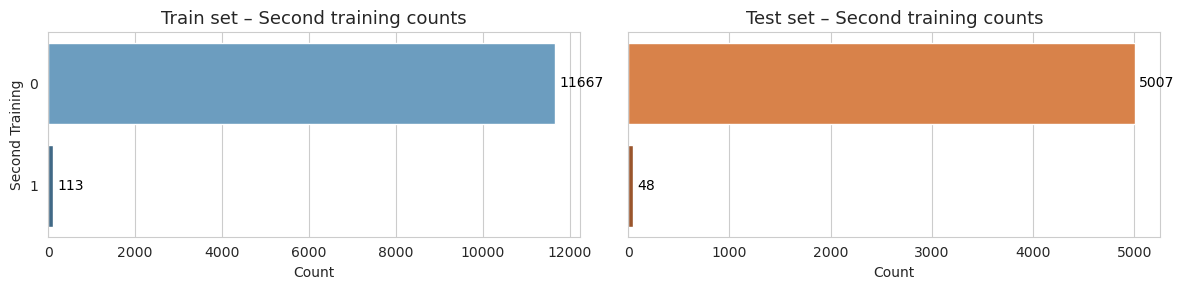

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3), sharey=True)

# Train
ax = axes[0]
sns.countplot(data=train_df, y='has_second_training', order=train_df['has_second_training'].value_counts().index, ax=axes[0], palette='Blues_d')
axes[0].set_title('Train set – Second training counts', fontsize=13)
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Second Training')
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3, fontsize=10, color='black')

# Test
ax = axes[1]
sns.countplot(data=test_df, y='has_second_training', order=test_df['has_second_training'].value_counts().index, ax=axes[1], palette='Oranges_d')
axes[1].set_title('Test set – Second training counts', fontsize=13)
axes[1].set_xlabel('Count')
axes[1].set_ylabel('')
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3, fontsize=10, color='black')
plt.tight_layout()
plt.show()

### 2.5.10 Addressing Problematic Issues for `ward` and `subcounty` features

In [50]:
# Define known categories from TRAIN only
known_wards = set(train_df['ward'].unique())
known_subcounties = set(train_df['subcounty'].unique())

# Function to replace unseen categories with 'Other'
def replace_unseen_categories(df, col, known_set):
    df = df.copy()
    df[col] = df[col].apply(lambda x: x if x in known_set else 'Other')
    return df

# Apply to both train and test for consistency
train_df = replace_unseen_categories(train_df, 'ward', known_wards)
test_df = replace_unseen_categories(test_df, 'ward', known_wards)

train_df = replace_unseen_categories(train_df, 'subcounty', known_subcounties)
test_df = replace_unseen_categories(test_df, 'subcounty', known_subcounties)

# Collapse placeholder values like "Select Your..." explicitly
placeholder_values = ['Select Your Ward', 'Select Your Sub County']
for col in ['ward', 'subcounty']:
    if col in train_df.columns:
        train_df[col] = train_df[col].replace(placeholder_values, 'Other')
    if col in test_df.columns:
        test_df[col] = test_df[col].replace(placeholder_values, 'Other')

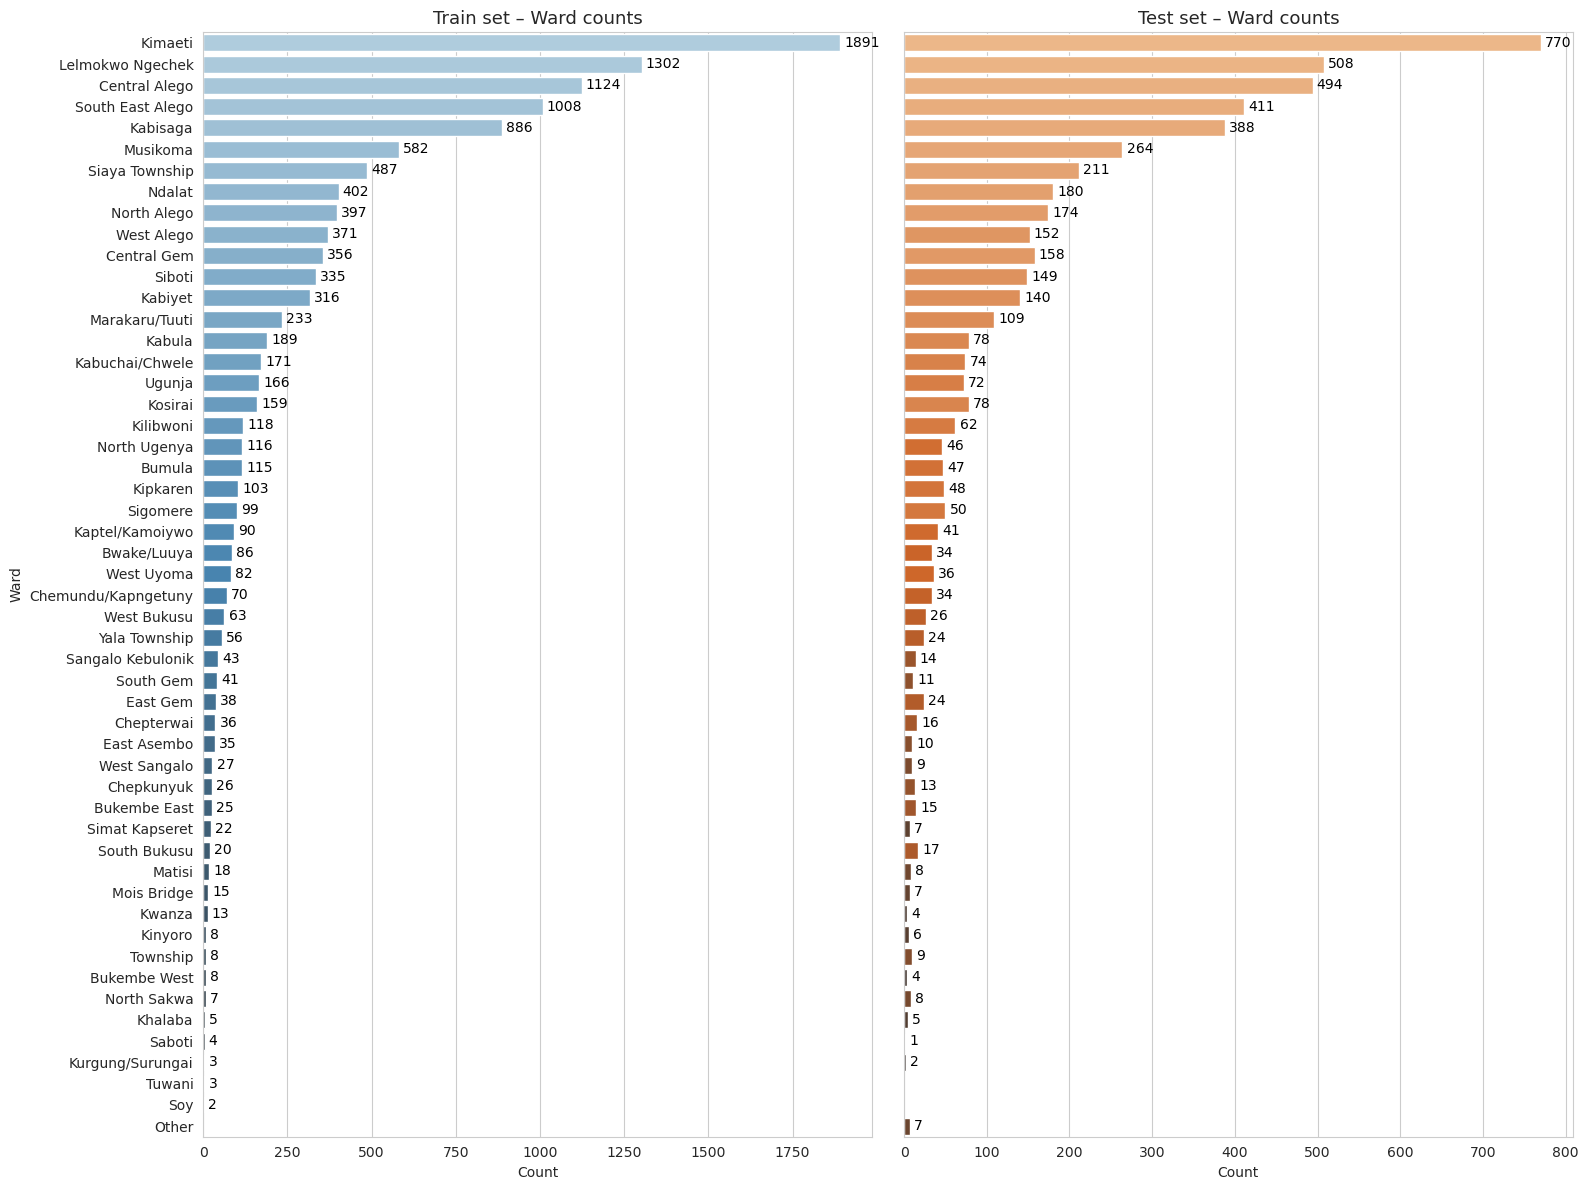

In [51]:
# Confirm if issue addressed for the ward feature
fig, axes = plt.subplots(1, 2, figsize=(16, 12), sharey=True)

# Train
ax = axes[0]
sns.countplot(data=train_df, y='ward', order=train_df['ward'].value_counts().index, ax=axes[0], palette='Blues_d')
axes[0].set_title('Train set – Ward counts', fontsize=13)
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Ward')
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3, fontsize=10, color='black')

# Test
ax = axes[1]
sns.countplot(data=test_df, y='ward', order=test_df['ward'].value_counts().index, ax=axes[1], palette='Oranges_d')
axes[1].set_title('Test set – Ward counts', fontsize=13)
axes[1].set_xlabel('Count')
axes[1].set_ylabel('')
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3, fontsize=10, color='black')

plt.tight_layout()
plt.show()

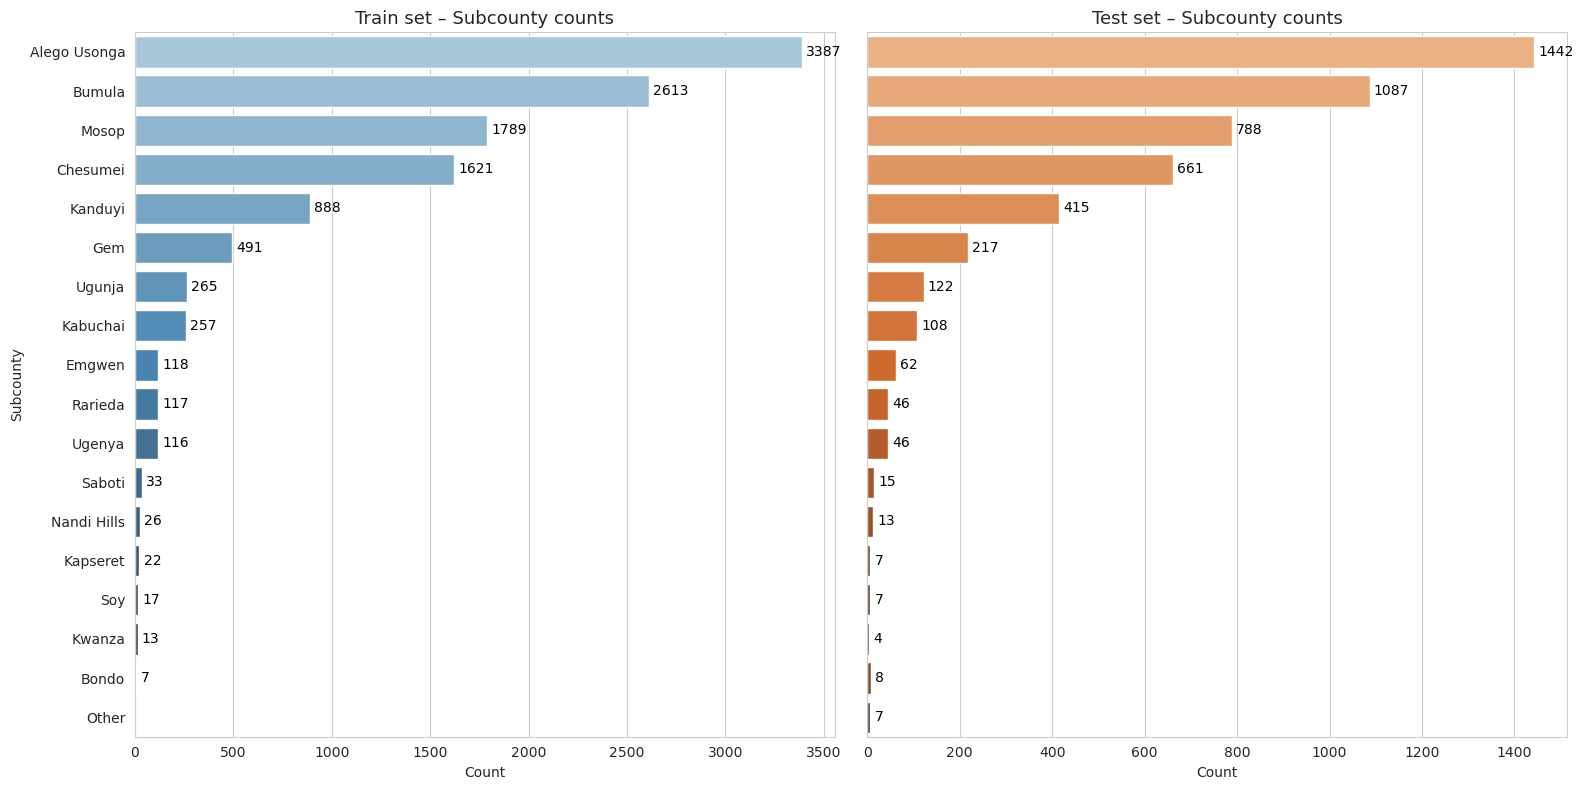

In [52]:
# Confirm if issue addressed for the ward feature
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# Train
ax = axes[0]
sns.countplot(data=train_df, y='subcounty', order=train_df['subcounty'].value_counts().index, ax=axes[0], palette='Blues_d')
axes[0].set_title('Train set – Subcounty counts', fontsize=13)
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Subcounty')
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3, fontsize=10, color='black')

# Test
ax = axes[1]
sns.countplot(data=test_df, y='subcounty', order=test_df['subcounty'].value_counts().index, ax=axes[1], palette='Oranges_d')
axes[1].set_title('Test set – Subcounty counts', fontsize=13)
axes[1].set_xlabel('Count')
axes[1].set_ylabel('')
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3, fontsize=10, color='black')
plt.tight_layout()
plt.show()

### 2.6 Categorical Features vs. Target Analysis 

- Leverage cross-tabulation to compute the percentage distribuction of the categorical features within each `target` class.
- The findings are crucial in highlighting potential correlations between categorical features and `target`.
- Feature-target relationships are crucial for informing: feature selection, encoding strategies, and model interpretability.
- Features with strong association with `target` are prime candidates for inclusion in predictive models.
- Crucial for providing a solid foundations for data-drive feature engineering and guide prioritization strategy for features with a high potential for driving models's predictive performance. 

In [53]:
# Categorical features vs. target analysis 
if 'target' in train_df.columns:
    print("Categorical Features' Relationships with Target")

    # Categorical features vs target
    print("\n Key Categorical Features by Target:")
    key_cat = ['gender', 'age', 'registration', 'belong_to_cooperative', 
               'trainer', 'has_second_training', 'county', 'subcounty', 'ward']
    for col in key_cat:
        if col in train_df.columns:
            print(f"\n{col} distribution by Target:")
            ct = pd.crosstab(train_df[col], train_df['target'], normalize='index') * 100
            print(ct.round(2))

Categorical Features' Relationships with Target

 Key Categorical Features by Target:

gender distribution by Target:
target      0     1
gender             
Female  97.38  2.62
Male    97.74  2.26

age distribution by Target:
target        0     1
age                  
Above 35  97.41  2.59
Below 35  97.80  2.20

registration distribution by Target:
target            0     1
registration             
Manual        98.62  1.38
Ussd          97.03  2.97

belong_to_cooperative distribution by Target:
target                     0     1
belong_to_cooperative             
0                      97.47  2.53
1                      97.55  2.45

trainer distribution by Target:
target               0     1
trainer                     
Other            93.10  6.90
trainer_name_2   96.65  3.35
trainer_name_3   96.20  3.80
trainer_name_4  100.00  0.00
trainer_name_5   99.29  0.71

has_second_training distribution by Target:
target                   0      1
has_second_training              
0      

## 2.7 Data Quality Checks

- Count duplicate IDs in train_df and test_df
- Identify overlapping IDs in both train_df and test_df

In [54]:
# Data quality check

# Check for duplicate IDs
print(f"\nDuplicate IDs in Train: {train_df['ID'].duplicated().sum()}")
print(f"Duplicate IDs in Test: {test_df['ID'].duplicated().sum()}")

# Check for ID overlap
id_overlap = set(train_df['ID']).intersection(set(test_df['ID']))
print(f"Overlapping IDs between Train and Test: {len(id_overlap)}")

# Check feature consistency
train_cols = set(train_df.columns) - {'target'}
test_cols = set(test_df.columns)
missing_in_test = train_cols - test_cols
extra_in_test = test_cols - train_cols

if missing_in_test:
    print(f"\n Features in Train but not in Test: {missing_in_test}")
if extra_in_test:
    print(f"\n Features in Test but not in Train: {extra_in_test}")
if not missing_in_test and not extra_in_test:
    print("\n Feature sets are consistent (except target variable)")


Duplicate IDs in Train: 0
Duplicate IDs in Test: 0
Overlapping IDs between Train and Test: 0

 Feature sets are consistent (except target variable)


In [55]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11780 entries, 0 to 11779
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ID                     11780 non-null  object        
 1   gender                 11780 non-null  object        
 2   age                    11780 non-null  object        
 3   registration           11780 non-null  object        
 4   belong_to_cooperative  11780 non-null  object        
 5   county                 11780 non-null  object        
 6   subcounty              11780 non-null  object        
 7   ward                   11780 non-null  object        
 8   trainer                11780 non-null  object        
 9   first_training_date    11780 non-null  datetime64[ns]
 10  topics_list            11780 non-null  object        
 11  num_trainings_30d      11780 non-null  int64         
 12  num_trainings_60d      11780 non-null  int64         
 13  n

In [56]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5055 entries, 0 to 5054
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ID                     5055 non-null   object        
 1   gender                 5055 non-null   object        
 2   age                    5055 non-null   object        
 3   registration           5055 non-null   object        
 4   belong_to_cooperative  5055 non-null   object        
 5   county                 5055 non-null   object        
 6   subcounty              5055 non-null   object        
 7   ward                   5055 non-null   object        
 8   trainer                5055 non-null   object        
 9   first_training_date    5055 non-null   datetime64[ns]
 10  topics_list            5055 non-null   object        
 11  num_trainings_30d      5055 non-null   float64       
 12  num_trainings_60d      5055 non-null   float64       
 13  num

## 3 Feature Engineering

### 3.1 Handle Train/Test Category Mismatches 

In [57]:
# Ensure consistent categories in ward and subcounty
def align_categories(train_df, test_df, col):
    known_vals = set(train_df[col].unique())
    test_df[col] = test_df[col].apply(lambda x: x if x in known_vals else 'Other')
    return train_df, test_df

train_df, test_df = align_categories(train_df, test_df, 'ward')
train_df, test_df = align_categories(train_df, test_df, 'subcounty')

# Also explicitly collapse placeholder values
placeholders = ['Select Your Ward', 'Select Your Sub County']
for col in ['ward', 'subcounty']:
    train_df[col] = train_df[col].replace(placeholders, 'Other')
    test_df[col] = test_df[col].replace(placeholders, 'Other')

### 3.2 Engineer Temporal Features from `first_training_date`

In [58]:
# Engineer temporal features
for df in [train_df, test_df]:
    df['training_month'] = df['first_training_date'].dt.month
    df['training_dayofyear'] = df['first_training_date'].dt.dayofyear
    df['training_weekofyear'] = df['first_training_date'].dt.isocalendar().week.astype(int)
    df['training_quarter'] = df['first_training_date'].dt.quarter
    
    # Engineer feature to capture whether training occured during dry season
    df['is_dry_season'] = df['training_month'].isin([1, 2, 6, 7, 8]).astype(int)  

### 3.3 Encode `topics_list` Feature

- Extract individual topics.
- Count number of topics.
- Creat binary flags for top-N impactful topics

In [59]:
# # Encode the `topics_list` feature
# def parse_topics(df):
#     df = df.copy()
#     df['topics_parsed'] = df['topics_list'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])
#     df['num_topics'] = df['topics_parsed'].apply(len)
#     return df

# train_df = parse_topics(train_df)
# test_df = parse_topics(test_df)

# # Flatten all topics to find top ones
# all_topics = [topic for sublist in train_df['topics_parsed'] for topic in sublist]
# top_topics = [t for t, _ in Counter(all_topics).most_common(10)]  # Top 10

# # Create binary flags
# for topic in top_topics:
#     col_name = f"topic_{topic.replace(' ', '_').replace('.', '').lower()}"
#     train_df[col_name] = train_df['topics_parsed'].apply(lambda x: topic in x).astype(int)
#     test_df[col_name] = test_df['topics_parsed'].apply(lambda x: topic in x).astype(int)

# # Drop raw topics_list and parsed version
# train_df.drop(columns=['topics_list', 'topics_parsed'], inplace=True)
# test_df.drop(columns=['topics_list', 'topics_parsed'], inplace=True)

In [60]:
import ast
import pandas as pd
import numpy as np
from collections import Counter

def extract_independent_topics(df):
    """
    Parse topics_list and split comma-separated values within list elements
    to extract independent topics. Returns normalized list of topics per row.
    """
    df = df.copy()
    
    def parse_and_split(x):
        if pd.isna(x) or x == '' or x == '[]':
            return []
        try:
            # Parse string representation of list
            parsed = ast.literal_eval(x) if isinstance(x, str) else x
            if not isinstance(parsed, list):
                parsed = [parsed]
            
            # Split each element by comma and flatten
            independent = []
            for item in parsed:
                if isinstance(item, str):
                    # Split by comma and clean each topic
                    parts = [p.strip() for p in item.split(',') if p.strip()]
                    independent.extend(parts)
            return independent
        except:
            return []
    
    df['topics_parsed'] = df['topics_list'].apply(parse_and_split)
    return df

# Apply parsing to both datasets
train_df = extract_independent_topics(train_df)
test_df = extract_independent_topics(test_df)

# Step 2: Extract ALL unique independent topics across BOTH datasets
all_topics_train = [topic for sublist in train_df['topics_parsed'] for topic in sublist]
all_topics_test = [topic for sublist in test_df['topics_parsed'] for topic in sublist]
all_unique_topics = sorted(set(all_topics_train + all_topics_test))

print(f"Total unique independent topics extracted: {len(all_unique_topics)}")
print(f"Example topics: {all_unique_topics[:10]}")

# Step 3 & 4: Create binary features for ALL topics with normalized column names
def normalize_topic_name(topic):
    """Normalize topic name for column creation: lowercase, replace spaces/punctuation with underscores"""
    topic = topic.lower()
    topic = topic.replace(' ', '_').replace('-', '_').replace('.', '_').replace('/', '_')
    topic = ''.join(c if c.isalnum() or c == '_' else '_' for c in topic)
    topic = '_'.join(filter(None, topic.split('_')))  # Remove duplicate underscores
    return topic

# Create mapping of original topic -> normalized column name
topic_to_col = {topic: f"topic_{normalize_topic_name(topic)}" for topic in all_unique_topics}

# Handle potential duplicate column names after normalization
from collections import defaultdict
col_to_topics = defaultdict(list)
for topic, col in topic_to_col.items():
    col_to_topics[col].append(topic)

# Warn about duplicates (topics that normalize to same column name)
duplicates = {col: topics for col, topics in col_to_topics.items() if len(topics) > 1}
if duplicates:
    print(f"\n⚠️ Warning: {len(duplicates)} column name collisions after normalization (topics merged):")
    for col, topics in list(duplicates.items())[:12]:  # Show first 5
        print(f"  {col}: {topics[:3]}{'...' if len(topics) > 3 else ''}")

# Create binary features for each UNIQUE normalized column
for col_name, topics in col_to_topics.items():
    # Topic present if ANY of its source topics appear in the row
    train_df[col_name] = train_df['topics_parsed'].apply(
        lambda x: int(any(topic in x for topic in topics))
    )
    test_df[col_name] = test_df['topics_parsed'].apply(
        lambda x: int(any(topic in x for topic in topics))
    )

# Optional: Add topic count feature
train_df['num_independent_topics'] = train_df['topics_parsed'].apply(len)
test_df['num_independent_topics'] = test_df['topics_parsed'].apply(len)

# Step 5: Cleanup
train_df.drop(columns=['topics_list', 'topics_parsed'], inplace=True)
test_df.drop(columns=['topics_list', 'topics_parsed'], inplace=True)

print(f"\n✅ Created {len(col_to_topics)} binary topic features")
print(f"   Train shape: {train_df.shape}")
print(f"   Test shape: {test_df.shape}")

Total unique independent topics extracted: 121
Example topics: ['Aflatoxin In Dairy Farming', 'Antimicrobial Resistance', 'Asili Fertilizer (Organic)', 'Benefits Of Sistema Biogas', 'Benefits Of Sistema Biogas.', 'Benfits Of Sistema Biogas', 'Benfits Of Sistema Biogas.', 'Biodeal Dairy', 'Biodeal Poultry', 'Biosecurity In Poultry Farming']

⚠️ Warning: 11 column name collisions after normalization (topics merged):
  topic_benefits_of_sistema_biogas: ['Benefits Of Sistema Biogas', 'Benefits Of Sistema Biogas.']
  topic_benfits_of_sistema_biogas: ['Benfits Of Sistema Biogas', 'Benfits Of Sistema Biogas.']
  topic_control_of_external_parasites_with_dominex: ['Control Of External Parasites With Dominex', 'Control Of External Parasites With Dominex.']
  topic_herd_health_management: ['Herd Health Management', 'Herd Health Management.', 'Herd. Health. Management']
  topic_herd_health_practices_with_biodeal_products: ['Herd Health Practices With Biodeal Products', 'Herd Health Practices With 

In [61]:
# import ast
# import re
# import pandas as pd
# import numpy as np
# from collections import defaultdict, Counter
# import nltk
# from nltk.corpus import words as nltk_words
# from nltk.metrics.distance import edit_distance

# # # Download required NLTK resources (run once)
# # try:
# #     ENGLISH_WORDS = set(word.lower() for word in nltk_words.words())
# # except LookupError:
# #     nltk.download('words')
# #     ENGLISH_WORDS = set(word.lower() for word in nltk_words.words())


# ENGLISH_WORDS = set(word.lower() for word in nltk_words.words())

# def build_correction_cache(word_list, max_distance=1):
#     """
#     Precompute corrections for common misspellings to improve performance.
#     Returns dict: {misspelled: corrected}
#     """
#     cache = {}
#     for word in word_list:
#         if word not in ENGLISH_WORDS and len(word) > 2:
#             # Find closest valid English word within edit distance threshold
#             candidates = [
#                 w for w in ENGLISH_WORDS 
#                 if abs(len(w) - len(word)) <= max_distance 
#                 and edit_distance(word, w) <= max_distance
#             ]
#             if candidates:
#                 # Choose candidate with smallest edit distance (and alphabetically first on tie)
#                 best = min(candidates, key=lambda w: (edit_distance(word, w), w))
#                 cache[word] = best
#     return cache

# def clean_and_correct_text(text, correction_cache=None, domain_whitelist=None):
#     """
#     Clean text with regex, then correct spelling using NLTK words corpus.
    
#     Args:
#         text: Raw string to process
#         correction_cache: Precomputed dict of {misspelled: corrected} (optional but recommended)
#         domain_whitelist: Set of domain terms to NEVER correct
    
#     Returns:
#         Cleaned and spell-corrected string
#     """
#     if not isinstance(text, str) or not text.strip():
#         return text
    
#     # 1. Regex cleaning: normalize punctuation/whitespace while preserving commas for splitting
#     text = text.lower()
#     text = re.sub(r'[^a-z0-9\s,]', ' ', text)  # Keep only alphanum, spaces, commas
#     text = re.sub(r'\s+', ' ', text).strip()
    
#     # 2. Spell correction with domain protection
#     words = text.split()
#     corrected = []
    
#     for word in words:
#         # Skip correction for domain terms or very short words
#         if (domain_whitelist and word in domain_whitelist) or len(word) <= 2:
#             corrected.append(word)
#             continue
        
#         # Use cache if available
#         if correction_cache and word in correction_cache:
#             corrected.append(correction_cache[word])
#             continue
        
#         # Fallback: check against English dictionary
#         if word in ENGLISH_WORDS:
#             corrected.append(word)
#         else:
#             # Conservative correction: only fix 1-character errors
#             candidates = [
#                 w for w in ENGLISH_WORDS 
#                 if abs(len(w) - len(word)) <= 1 
#                 and edit_distance(word, w) == 1
#             ]
#             if candidates:
#                 best = min(candidates, key=lambda w: (edit_distance(word, w), w))
#                 corrected.append(best)
#             else:
#                 corrected.append(word)  # Keep original if no confident correction
    
#     return ' '.join(corrected)

# def extract_and_correct_topics(df, correction_cache=None, domain_whitelist=None):
#     """
#     Parse topics_list, clean/correct text using NLTK, then split by commas 
#     to extract independent topics.
#     """
#     df = df.copy()
    
#     def parse_split_correct(x):
#         if pd.isna(x) or x == '' or x == '[]':
#             return []
        
#         try:
#             # Parse string representation of list
#             parsed = ast.literal_eval(x) if isinstance(x, str) else x
#             if not isinstance(parsed, list):
#                 parsed = [parsed] if parsed else []
            
#             independent = []
#             for item in parsed:
#                 if isinstance(item, str) and item.strip():
#                     # Clean and correct the entire string
#                     cleaned = clean_and_correct_text(
#                         item, 
#                         correction_cache=correction_cache,
#                         domain_whitelist=domain_whitelist
#                     )
#                     # Split by comma to extract independent topics
#                     parts = [p.strip() for p in cleaned.split(',') if p.strip()]
#                     independent.extend(parts)
#             return independent
#         except Exception as e:
#             # Silent fallback on error (log if needed)
#             return []
    
#     df['topics_parsed'] = df['topics_list'].apply(lambda x: parse_split_correct(x))
#     return df

# # ==================== PREPROCESSING PIPELINE ====================
# print("🔍 Building spell correction cache...")

# # 1. Extract ALL raw words from topics_list for cache building
# all_raw_texts = pd.concat([
#     train_df['topics_list'].dropna().astype(str),
#     test_df['topics_list'].dropna().astype(str)
# ])
# all_words = set()
# for text in all_raw_texts:
#     try:
#         parsed = ast.literal_eval(text) if isinstance(text, str) else text
#         if isinstance(parsed, list):
#             for item in parsed:
#                 if isinstance(item, str):
#                     # Extract words before cleaning
#                     words = re.findall(r'\b[a-z]{3,}\b', item.lower())
#                     all_words.update(words)
#     except:
#         pass

# # 2. Build correction cache (significantly speeds up processing)
# correction_cache = build_correction_cache(all_words, max_distance=1)
# print(f"   ✅ Built correction cache for {len(correction_cache)} potential misspellings")

# # 3. DOMAIN WHITELIST (critical for agricultural/technical terms)
# domain_terms = {
#     'calf', 'heifer', 'lactating', 'lactation', 'colostrum', 'forage', 'silage',
#     'pasture', 'manure', 'vaccination', 'deworming', 'calving', 'breeding',
#     'milking', 'udder', 'mastitis', 'ruminant', 'concentrate', 'haylage',
#     'cow', 'bull', 'steer', 'feed', 'feeding', 'grazing', 'fertilizer',
#     'pesticide', 'irrigation', 'harvest', 'yield', 'soil', 'crop', 'dairy'
# }
# # Augment with frequent domain words from dataset
# domain_terms.update(word for word in all_words if len(word) >= 4 and word not in ENGLISH_WORDS)
# print(f"   🛡️ Domain whitelist size: {len(domain_terms)} terms")

# # ==================== PROCESS DATASETS ====================
# print("\n🧹 Cleaning and correcting topics...")
# train_df = extract_and_correct_topics(
#     train_df, 
#     correction_cache=correction_cache,
#     domain_whitelist=domain_terms
# )
# test_df = extract_and_correct_topics(
#     test_df,
#     correction_cache=correction_cache,
#     domain_whitelist=domain_terms
# )

# # ==================== EXTRACT ALL UNIQUE TOPICS ====================
# all_topics_train = [topic for sublist in train_df['topics_parsed'] for topic in sublist]
# all_topics_test = [topic for sublist in test_df['topics_parsed'] for topic in sublist]
# all_unique_topics = sorted(set(all_topics_train + all_topics_test))

# print(f"\n📊 Total unique independent topics after cleaning/correction: {len(all_unique_topics)}")
# print(f"   Top 10 topics by frequency: {Counter(all_topics_train).most_common(10)}")

# # ==================== CREATE BINARY FEATURES ====================
# def normalize_topic_name(topic):
#     """Create safe, consistent column name from topic string"""
#     topic = re.sub(r'[^a-z0-9\s]', ' ', topic.lower())
#     topic = re.sub(r'\s+', '_', topic.strip())
#     topic = re.sub(r'_+', '_', topic)
#     return f"topic_{topic}" if topic else "topic_unknown"

# # Map topics to normalized column names (handle collisions)
# topic_to_col = {topic: normalize_topic_name(topic) for topic in all_unique_topics}
# col_to_topics = defaultdict(list)
# for topic, col in topic_to_col.items():
#     col_to_topics[col].append(topic)

# # Warn about normalization collisions
# collisions = {col: topics for col, topics in col_to_topics.items() if len(topics) > 1}
# if collisions:
#     print(f"\n⚠️ {len(collisions)} column name collisions detected (topics merged):")
#     for i, (col, topics) in enumerate(list(collisions.items())[:5]):
#         print(f"   {col}: {topics[:3]}{'...' if len(topics) > 3 else ''}")

# # Create binary features (vectorized for performance)
# print(f"\n⚙️ Creating {len(col_to_topics)} binary topic features...")
# for col_name, topics in col_to_topics.items():
#     topic_set = set(topics)
#     train_df[col_name] = train_df['topics_parsed'].apply(
#         lambda x: 1 if topic_set.intersection(x) else 0
#     )
#     test_df[col_name] = test_df['topics_parsed'].apply(
#         lambda x: 1 if topic_set.intersection(x) else 0
#     )

# # Add topic count feature
# train_df['num_independent_topics'] = train_df['topics_parsed'].apply(len)
# test_df['num_independent_topics'] = test_df['topics_parsed'].apply(len)

# # ==================== CLEANUP ====================
# train_df.drop(columns=['topics_list', 'topics_parsed'], inplace=True, errors='ignore')
# test_df.drop(columns=['topics_list', 'topics_parsed'], inplace=True, errors='ignore')

# print(f"\n✅ Processing complete!")
# print(f"   Train shape: {train_df.shape}")
# print(f"   Test shape: {test_df.shape}")
# print(f"   Binary topic features created: {len(col_to_topics)}")

# # ==================== OPTIONAL: VALIDATION SAMPLE ====================
# print("\n🔍 Sample of corrected topics (first 5 rows):")
# for i in range(min(5, len(train_df))):
#     # Reconstruct original topics for comparison (if still available in original df)
#     print(f"   Row {i}: {train_df.filter(like='topic_', axis=1).iloc[i].sum()} topics detected")

In [62]:
# import ast
# import re
# import pandas as pd
# from collections import defaultdict, Counter
# from spellchecker import SpellChecker  # pip install pyspellchecker

# def clean_and_correct_text(text, spell_checker, domain_whitelist=None):
#     """
#     Clean text with regex and correct spelling while protecting domain terms.
    
#     Args:
#         text: Raw string to process
#         spell_checker: Initialized SpellChecker instance
#         domain_whitelist: Set of domain-specific terms to NEVER correct (e.g., {'calf', 'lactating'})
    
#     Returns:
#         Cleaned and spell-corrected string
#     """
#     if not isinstance(text, str) or not text.strip():
#         return text
    
#     # 1. Regex cleaning: lowercase + normalize whitespace/punctuation
#     text = text.lower()
#     text = re.sub(r'[^\w\s,]', ' ', text)  # Replace punctuation (except commas) with space
#     text = re.sub(r'\s+', ' ', text).strip()  # Collapse multiple spaces
    
#     # 2. Spell correction with domain-term protection
#     words = text.split()
#     corrected_words = []
    
#     for word in words:
#         # Skip correction for whitelisted domain terms or very short words
#         if domain_whitelist and word in domain_whitelist or len(word) <= 2:
#             corrected_words.append(word)
#             continue
        
#         # Only correct if word is misspelled AND correction is confident
#         if word in spell_checker:
#             corrected_words.append(word)  # Already correct
#         else:
#             correction = spell_checker.correction(word)
#             # Accept correction only if it exists and isn't drastically different
#             if correction and len(correction) >= len(word) - 2:
#                 corrected_words.append(correction)
#             else:
#                 corrected_words.append(word)  # Keep original if uncertain
    
#     return ' '.join(corrected_words)

# def extract_and_correct_topics(df, spell_checker, domain_whitelist=None):
#     """
#     Parse topics_list, clean/correct text, then split comma-separated values 
#     to extract independent topics.
#     """
#     df = df.copy()
    
#     def parse_split_correct(x):
#         if pd.isna(x) or x == '' or x == '[]':
#             return []
        
#         try:
#             # Parse string representation of list
#             parsed = ast.literal_eval(x) if isinstance(x, str) else x
#             if not isinstance(parsed, list):
#                 parsed = [parsed]
            
#             independent = []
#             for item in parsed:
#                 if isinstance(item, str):
#                     # Clean and correct the entire string first
#                     cleaned = clean_and_correct_text(item, spell_checker, domain_whitelist)
#                     # Split by comma to extract independent topics
#                     parts = [p.strip() for p in cleaned.split(',') if p.strip()]
#                     independent.extend(parts)
#             return independent
#         except Exception as e:
#             print(f"⚠️ Parsing error: {e} | Input: {x}")
#             return []
    
#     df['topics_parsed'] = df['topics_list'].apply(lambda x: parse_split_correct(x))
#     return df

# # ==================== CONFIGURATION ====================
# # 1. Initialize spell checker (English dictionary)
# spell = SpellChecker(distance=1)  # distance=1 for conservative corrections

# # 2. DOMAIN WHITELIST (CRITICAL FOR AGRICULTURAL/TECHNICAL TERMS)
# # Add domain-specific terms that should NEVER be corrected
# domain_terms = {
#     'calf', 'heifer', 'lactating', 'lactation', 'colostrum', 'forage', 'silage',
#     'pasture', 'manure', 'vaccination', 'deworming', 'calving', 'breeding',
#     'milking', 'udder', 'mastitis', 'ruminant', 'concentrate', 'haylage'
# }
# # Expand with terms found in your data:
# all_raw_texts = pd.concat([train_df['topics_list'].dropna(), test_df['topics_list'].dropna()])
# domain_terms.update(set(re.findall(r'\b\w{4,}\b', ' '.join(all_raw_texts.astype(str)).lower())))

# print(f"🛡️ Domain whitelist size: {len(domain_terms)} terms")
# print(f"   Sample terms: {sorted(list(domain_terms))[:15]}")

# # ==================== PROCESS DATASETS ====================
# # Apply cleaning, correction, and topic extraction
# train_df = extract_and_correct_topics(train_df, spell, domain_whitelist=domain_terms)
# test_df = extract_and_correct_topics(test_df, spell, domain_whitelist=domain_terms)

# # ==================== EXTRACT ALL UNIQUE TOPICS ====================
# all_topics_train = [topic for sublist in train_df['topics_parsed'] for topic in sublist]
# all_topics_test = [topic for sublist in test_df['topics_parsed'] for topic in sublist]
# all_unique_topics = sorted(set(all_topics_train + all_topics_test))

# print(f"\n📊 Total unique independent topics after cleaning/correction: {len(all_unique_topics)}")
# print(f"   Top 10 topics: {Counter(all_topics_train).most_common(10)}")

# # ==================== CREATE BINARY FEATURES ====================
# def normalize_topic_name(topic):
#     """Create safe column name from topic string"""
#     topic = re.sub(r'[^\w\s]', ' ', topic.lower())
#     topic = re.sub(r'\s+', '_', topic.strip())
#     topic = re.sub(r'_+', '_', topic)
#     return f"topic_{topic}" if topic else "topic_unknown"

# # Map topics to normalized column names (handle collisions)
# topic_to_col = {topic: normalize_topic_name(topic) for topic in all_unique_topics}
# col_to_topics = defaultdict(list)
# for topic, col in topic_to_col.items():
#     col_to_topics[col].append(topic)

# # Warn about normalization collisions
# collisions = {col: topics for col, topics in col_to_topics.items() if len(topics) > 1}
# if collisions:
#     print(f"\n⚠️ {len(collisions)} column name collisions detected (topics merged):")
#     for i, (col, topics) in enumerate(list(collisions.items())[:5]):
#         print(f"   {col}: {topics[:3]}{'...' if len(topics) > 3 else ''}")

# # Create binary features
# for col_name, topics in col_to_topics.items():
#     train_df[col_name] = train_df['topics_parsed'].apply(
#         lambda x: int(any(topic in x for topic in topics))
#     )
#     test_df[col_name] = test_df['topics_parsed'].apply(
#         lambda x: int(any(topic in x for topic in topics))
#     )

# # Add topic count feature
# train_df['num_independent_topics'] = train_df['topics_parsed'].apply(len)
# test_df['num_independent_topics'] = test_df['topics_parsed'].apply(len)

# # ==================== CLEANUP ====================
# train_df.drop(columns=['topics_list', 'topics_parsed'], inplace=True, errors='ignore')
# test_df.drop(columns=['topics_list', 'topics_parsed'], inplace=True, errors='ignore')

# print(f"\n✅ Processing complete!")
# print(f"   Train shape: {train_df.shape} | Test shape: {test_df.shape}")
# print(f"   Binary topic features created: {len(col_to_topics)}")

### 3.4 Derive Interaction and Behavioural Features

In [63]:
# Training intensity signals
for df in [train_df, test_df]:
    df['repeat_within_30d'] = (df['num_trainings_30d'] > 1).astype(int)
    df['repeat_within_60d'] = (df['num_trainings_60d'] > 1).astype(int)
    df['training_frequency_30d'] = df['num_trainings_30d'] / 30.0
    df['training_frequency_60d'] = df['num_trainings_60d'] / 60.0

### 3.5 Target Encode High-Cardinality Categorical Features

In [64]:
# Define function for smoothed target encoding
def smoothed_target_encoding(train_df, test_df, cat_col, target_col='target', k=5, smooth=100):
    """
    K-fold smoothed target encoding to avoid leakage.
    """
    train_df = train_df.copy()
    test_df = test_df.copy()
    
    global_mean = train_df[target_col].mean()
    train_df[f'{cat_col}_enc'] = global_mean
    test_enc = pd.Series(index=test_df.index, dtype=float)
    
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    for train_idx, val_idx in kf.split(train_df):
        X_tr = train_df.iloc[train_idx]
        X_val = train_df.iloc[val_idx]
        
        stats = X_tr.groupby(cat_col)[target_col].agg(['mean', 'count'])
        stats['smoothed'] = (stats['mean'] * stats['count'] + global_mean * smooth) / (stats['count'] + smooth)
        mapping = stats['smoothed'].to_dict()
        
        train_df.loc[val_idx, f'{cat_col}_enc'] = X_val[cat_col].map(mapping).fillna(global_mean)
    
    # Fit on full train for test
    stats_full = train_df.groupby(cat_col)[target_col].agg(['mean', 'count'])
    stats_full['smoothed'] = (stats_full['mean'] * stats_full['count'] + global_mean * smooth) / (stats_full['count'] + smooth)
    mapping_full = stats_full['smoothed'].to_dict()
    test_enc = test_df[cat_col].map(mapping_full).fillna(global_mean)
    
    test_df[f'{cat_col}_enc'] = test_enc
    return train_df, test_df

# Apply to ward and subcounty (high cardinality + predictive potential)
train_df, test_df = smoothed_target_encoding(train_df, test_df, 'ward')
train_df, test_df = smoothed_target_encoding(train_df, test_df, 'subcounty')

### 3.6 One-Hot Encode Low-Cardinality Categorical Features

In [65]:
# Perform OHE on low-cardinality categoricals 
low_card_cols = ['gender', 'age', 'registration', 'belong_to_cooperative', 'has_second_training', 'county']
# low_card_cols = ['gender', 'age', 'registration', 'belong_to_cooperative', 'has_second_training', 'county', 'ward', 'subcounty', 'trainer']

# Combine for consistent encoding
combined = pd.concat([train_df[low_card_cols], test_df[low_card_cols]], ignore_index=True)
combined_encoded = pd.get_dummies(combined, columns=low_card_cols, prefix=low_card_cols, drop_first=True)

# Split back
train_encoded = combined_encoded.iloc[:len(train_df)]
test_encoded = combined_encoded.iloc[len(train_df):]

# Merge back
train_df = pd.concat([train_df.reset_index(drop=True), train_encoded.reset_index(drop=True)], axis=1)
test_df = pd.concat([test_df.reset_index(drop=True), test_encoded.reset_index(drop=True)], axis=1)

# Drop original low-card cols
train_df.drop(columns=low_card_cols, inplace=True)
test_df.drop(columns=low_card_cols, inplace=True)

### 3.7 Feature Engineering Cleanup

In [66]:
# Finalize
y = train_df['target'].astype(int)
X = train_df.drop(columns=['ID', 'target', 'first_training_date', 'ward', 'subcounty', 'trainer'])  # keep trainer? You kept it, but it's low-signal. We drop for LR/RF, keep for tree models.
# X = train_df.drop(columns=['ID', 'first_training_date', 'target']) 
X_test = test_df.drop(columns=['ID', 'first_training_date', 'ward', 'subcounty', 'trainer'])
# X_test = test_df.drop(columns=['ID','first_training_date'])

# Store IDs
train_ids = train_df['ID']
test_ids = test_df['ID']

In [67]:
# # Drop non-feature columns
# id_col = train_df['ID']
# target = train_df['target'].astype(int)

# # drop_cols = ['ID', 'first_training_date', 'ward', 'subcounty', 'trainer']  # trainer has low signal; keep only if needed
# drop_cols = ['ID', 'first_training_date', 'ward', 'subcounty']
# train_final = train_df.drop(columns=drop_cols + ['target'])
# test_final = test_df.drop(columns=drop_cols)

# # Ensure same columns
# common_cols = train_final.columns.intersection(test_final.columns)
# train_final = train_final[common_cols]
# test_final = test_final[common_cols]

# print(f"Final feature count: {train_final.shape[1]}")

In [68]:
# # Store IDs for later
# train_ids = train_df['ID']
# test_ids = test_df['ID']

# # Do NOT drop ID yet
# # Do NOT drop ward, subcounty, trainer — unless replaced by encodings

# # Example: After creating ward_enc, subcounty_enc, trainer_enc...
# # You may choose to DROP the original high-cardinality categoricals ONLY if:
# # - You've already encoded them
# # - You don't plan to use embeddings or other representations

# # But if you want to keep them for tree-based models (e.g., CatBoost, LightGBM),
# # you can leave them as strings — these models handle high-cardinality categoricals well.

# # So a safer approach for XGBoost/CatBoost:
# # → Keep 'ward', 'subcounty', 'trainer' as string columns
# # → Let the model handle them (CatBoost especially excels here)
# # → Only convert to numeric if using models that require it (e.g., logistic regression, neural nets)

# # For now, just ensure consistency:
# train_df, test_df = align_categories(train_df, test_df, 'ward')
# train_df, test_df = align_categories(train_df, test_df, 'subcounty')
# # trainer appears consistent (same 5 values), but still good to align
# train_df, test_df = align_categories(train_df, test_df, 'trainer')

## 4 Modelling

In [69]:
# # Stratified train/val split
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# # Scoring function
# def custom_score(y_true, y_proba):
#     ll = log_loss(y_true, y_proba, labels=[0,1])
#     auc = roc_auc_score(y_true, y_proba)
#     return 0.7 * (1 - ll) + 0.3 * auc, ll, auc

In [70]:
X_train = X
y_train = y
# Scoring function
def custom_score(y_true, y_proba):
    ll = log_loss(y_true, y_proba, labels=[0,1])
    auc = roc_auc_score(y_true, y_proba)
    return 0.7 * (1 - ll) + 0.3 * auc, ll, auc

### 4.1 LightGBM Classifier 

In [72]:
# # Vanilla LGBM
# import lightgbm as lgb

# train_data = lgb.Dataset(X_train, label=y_train)
# val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

# params = {
#     'objective': 'binary',
#     'metric': 'binary_logloss',
#     'boosting_type': 'gbdt',
#     'num_leaves': 31,
#     'learning_rate': 0.05,
#     'feature_fraction': 0.8,
#     'bagging_fraction': 0.8,
#     'random_state': 42,
#     'verbose': -1
# }

# model = lgb.train(
#     params,
#     train_data,
#     valid_sets=[val_data],
#     num_boost_round=500,
#     callbacks=[lgb.early_stopping(50, verbose=False)]
# )

# val_pred = model.predict(X_val)
# score, ll, auc = custom_score(y_val, val_pred)
# print(f"LightGBM – Custom Score: {score:.5f} | LogLoss: {ll:.5f} | AUC: {auc:.5f}")

# lgb_test_pred = model.predict(X_test)

### 4.2 XGBoost Classifier 

Starting 20-Fold Cross-Validation...

Fold 1 | LogLoss: 0.19670 | AUC: 0.95329
Fold 2 | LogLoss: 0.19996 | AUC: 0.95565
Fold 3 | LogLoss: 0.17207 | AUC: 0.97230
Fold 4 | LogLoss: 0.30761 | AUC: 0.99211
Fold 5 | LogLoss: 0.20473 | AUC: 0.98137
Fold 6 | LogLoss: 0.14382 | AUC: 0.97677
Fold 7 | LogLoss: 0.19070 | AUC: 0.96736
Fold 8 | LogLoss: 0.16692 | AUC: 0.97410
Fold 9 | LogLoss: 0.20523 | AUC: 0.96295
Fold 10 | LogLoss: 0.17275 | AUC: 0.97793
Fold 11 | LogLoss: 0.21092 | AUC: 0.95877
Fold 12 | LogLoss: 0.09532 | AUC: 0.98089
Fold 13 | LogLoss: 0.17021 | AUC: 0.98839
Fold 14 | LogLoss: 0.28008 | AUC: 0.95859
Fold 15 | LogLoss: 0.15346 | AUC: 0.94379
Fold 16 | LogLoss: 0.16911 | AUC: 0.95470
Fold 17 | LogLoss: 0.16771 | AUC: 0.97317
Fold 18 | LogLoss: 0.19294 | AUC: 0.95679
Fold 19 | LogLoss: 0.37604 | AUC: 0.95290
Fold 20 | LogLoss: 0.25547 | AUC: 0.94750

Overall CV LogLoss: 0.20159
Overall CV AUC: 0.96647


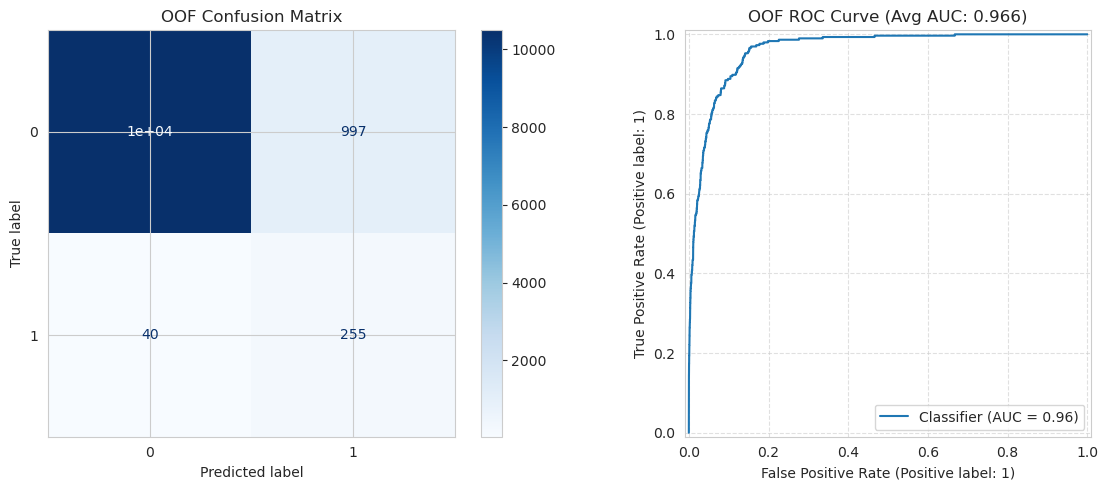

In [77]:
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay

# 1. Setup Stratified K-Fold
k_folds = 20
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Containers for results
oof_probs = np.zeros(len(X_train)) # Out-of-fold predictions
test_probs = np.zeros(len(X_test))  # Averaged test predictions
fold_metrics = []

print(f"Starting {k_folds}-Fold Cross-Validation...\n")

# 2. Cross-Validation Loop
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    # Split data
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Initialize Model
    model = xgb.XGBClassifier(
        n_estimators=1000, # Increased, but we'll use early stopping
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=len(y_fold_train) / y_fold_train.sum(),
        random_state=42,
        # eval_metric=['logloss'], # Optimize for logloss
        eval_metric=['auc'], # Optimize for auc
        early_stopping_rounds=50
    )
    
    # Fit Model
    model.fit(
        X_fold_train, y_fold_train, 
        eval_set=[(X_fold_val, y_fold_val)], 
        verbose=0
    )
    
    # Predict probabilities for validation and test
    fold_prob = model.predict_proba(X_fold_val)[:, 1]
    oof_probs[val_idx] = fold_prob
    test_probs += model.predict_proba(X_test)[:, 1] / k_folds
    
    # Calculate Fold Metrics
    ll = log_loss(y_fold_val, fold_prob)
    auc = roc_auc_score(y_fold_val, fold_prob)
    fold_metrics.append((ll, auc))
    
    print(f"Fold {fold+1} | LogLoss: {ll:.5f} | AUC: {auc:.5f}")

# 3. Final Scoring
avg_ll = np.mean([m[0] for m in fold_metrics])
avg_auc = np.mean([m[1] for m in fold_metrics])

print(f"\n{'='*30}")
print(f"Overall CV LogLoss: {avg_ll:.5f}")
print(f"Overall CV AUC: {avg_auc:.5f}")
print(f"{'='*30}")

# 4. Visualization (using Out-of-Fold predictions)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Confusion Matrix (using 0.5 threshold on OOF probs)
oof_preds = (oof_probs > 0.5).astype(int)
ConfusionMatrixDisplay.from_predictions(y_train, oof_preds, ax=ax1, cmap='Blues')
ax1.set_title("OOF Confusion Matrix")

# ROC Curve
RocCurveDisplay.from_predictions(y_train, oof_probs, ax=ax2)
ax2.set_title(f"OOF ROC Curve (Avg AUC: {avg_auc:.3f})")
ax2.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# Final Test Predictions
xgb_test_pred_scaled = test_probs

Starting 20-Fold CV (Optimizing LogLoss & AUC)...

Fold 1 | LogLoss: 0.07084 | AUC: 0.94366
Fold 2 | LogLoss: 0.06105 | AUC: 0.95733
Fold 3 | LogLoss: 0.14605 | AUC: 0.97006
Fold 4 | LogLoss: 0.04474 | AUC: 0.99056
Fold 5 | LogLoss: 0.03898 | AUC: 0.98870
Fold 6 | LogLoss: 0.07557 | AUC: 0.95708
Fold 7 | LogLoss: 0.05637 | AUC: 0.97456
Fold 8 | LogLoss: 0.06592 | AUC: 0.97178
Fold 9 | LogLoss: 0.06683 | AUC: 0.96028
Fold 10 | LogLoss: 0.05145 | AUC: 0.97915
Fold 11 | LogLoss: 0.06349 | AUC: 0.96225
Fold 12 | LogLoss: 0.05832 | AUC: 0.96870
Fold 13 | LogLoss: 0.05083 | AUC: 0.98827
Fold 14 | LogLoss: 0.06245 | AUC: 0.95302
Fold 15 | LogLoss: 0.09510 | AUC: 0.93670
Fold 16 | LogLoss: 0.06110 | AUC: 0.96179
Fold 17 | LogLoss: 0.05245 | AUC: 0.96527
Fold 18 | LogLoss: 0.05716 | AUC: 0.96446
Fold 19 | LogLoss: 0.06573 | AUC: 0.96283
Fold 20 | LogLoss: 0.06531 | AUC: 0.95168

CV Average LogLoss: 0.06549
CV Average AUC:     0.96541


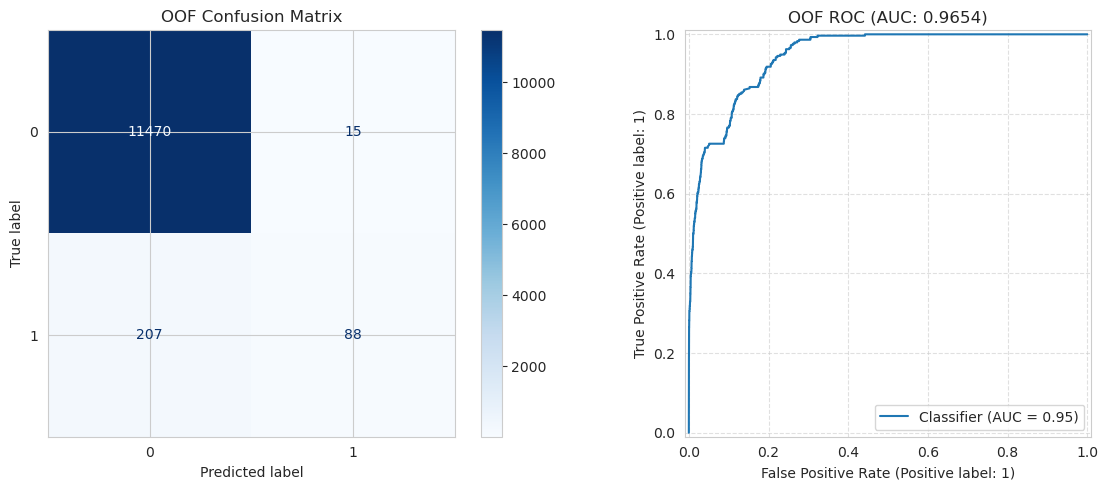

In [78]:
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay

# 1. Setup Stratified K-Fold
k_folds = 20
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Containers for results
oof_probs = np.zeros(len(X_train))  # To store predictions on the training set
test_probs = np.zeros(len(X_test))   # To store averaged test predictions
fold_metrics = []

print(f"Starting {k_folds}-Fold CV (Optimizing LogLoss & AUC)...\n")

# 2. Cross-Validation Loop
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    # Slice the data for this fold
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Initialize Model with your specific params
    model = xgb.XGBClassifier(
        n_estimators=1000,
        max_depth=4,
        learning_rate=0.04,
        subsample=1.0,
        colsample_bytree=0.8,
        random_state=42,
        # eval_metric=['logloss'], # Optimize for logloss
        eval_metric=['auc'], # Optimize for auc
        early_stopping_rounds=40,       # Prevents overfitting if logloss plateaus
        use_label_encoder=False
    )
    
    # Fit Model
    model.fit(
        X_fold_train, y_fold_train, 
        eval_set=[(X_fold_val, y_fold_val)], 
        verbose=0
    )
    
    # Get predictions for the validation fold
    fold_prob = model.predict_proba(X_fold_val)[:, 1]
    oof_probs[val_idx] = fold_prob
    
    # Add to test set predictions (averaging later)
    test_probs += model.predict_proba(X_test)[:, 1] / k_folds
    
    # Metrics for this fold
    ll = log_loss(y_fold_val, fold_prob)
    auc = roc_auc_score(y_fold_val, fold_prob)
    fold_metrics.append((ll, auc))
    
    print(f"Fold {fold+1} | LogLoss: {ll:.5f} | AUC: {auc:.5f}")

# 3. Final Scoring and Metrics Calculation
avg_ll = np.mean([m[0] for m in fold_metrics])
avg_auc = np.mean([m[1] for m in fold_metrics])

# If you still have your custom_score function:
# final_score, _, _ = custom_score(y_train, oof_probs)

print(f"\n{'='*40}")
print(f"CV Average LogLoss: {avg_ll:.5f}")
print(f"CV Average AUC:     {avg_auc:.5f}")
print(f"{'='*40}")

# 4. Visualization using Out-of-Fold (OOF) results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# OOF Confusion Matrix (using 0.5 threshold)
oof_pred_labels = (oof_probs > 0.5).astype(int)
ConfusionMatrixDisplay.from_predictions(y_train, oof_pred_labels, ax=ax1, cmap='Blues')
ax1.set_title("OOF Confusion Matrix")

# OOF ROC Curve
RocCurveDisplay.from_predictions(y_train, oof_probs, ax=ax2)
ax2.set_title(f"OOF ROC (AUC: {avg_auc:.4f})")
ax2.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# Final Test Predictions (averaged across all 5 models)
xgb_test_pred = test_probs

In [81]:
best_pred = xgb_test_pred  # replace with best model's test_pred
submission = pd.DataFrame({
    'ID': test_ids,
    'Target_AUC': best_pred,
    'Target_LogLoss': best_pred
})
submission.to_csv('regex_xgb_auc_20cv.csv', index=False)

### 4.5 Random Forest Classifier 

Starting 20-Fold CV for Random Forest...

Fold 1 | LogLoss: 0.14696 | AUC: 0.95776
Fold 2 | LogLoss: 0.13429 | AUC: 0.94559
Fold 3 | LogLoss: 0.14084 | AUC: 0.95404
Fold 4 | LogLoss: 0.14208 | AUC: 0.98932
Fold 5 | LogLoss: 0.13940 | AUC: 0.97255
Fold 6 | LogLoss: 0.16399 | AUC: 0.96609
Fold 7 | LogLoss: 0.13302 | AUC: 0.95935
Fold 8 | LogLoss: 0.14676 | AUC: 0.96388
Fold 9 | LogLoss: 0.14366 | AUC: 0.96655
Fold 10 | LogLoss: 0.15930 | AUC: 0.97329
Fold 11 | LogLoss: 0.13281 | AUC: 0.94541
Fold 12 | LogLoss: 0.14839 | AUC: 0.95697
Fold 13 | LogLoss: 0.12465 | AUC: 0.98118
Fold 14 | LogLoss: 0.15495 | AUC: 0.96922
Fold 15 | LogLoss: 0.14613 | AUC: 0.90883
Fold 16 | LogLoss: 0.14082 | AUC: 0.95279
Fold 17 | LogLoss: 0.14947 | AUC: 0.95389
Fold 18 | LogLoss: 0.15760 | AUC: 0.95447
Fold 19 | LogLoss: 0.13973 | AUC: 0.95947
Fold 20 | LogLoss: 0.16278 | AUC: 0.94878

RF CV Overall LogLoss: 0.14538
RF CV Overall AUC:     0.95897


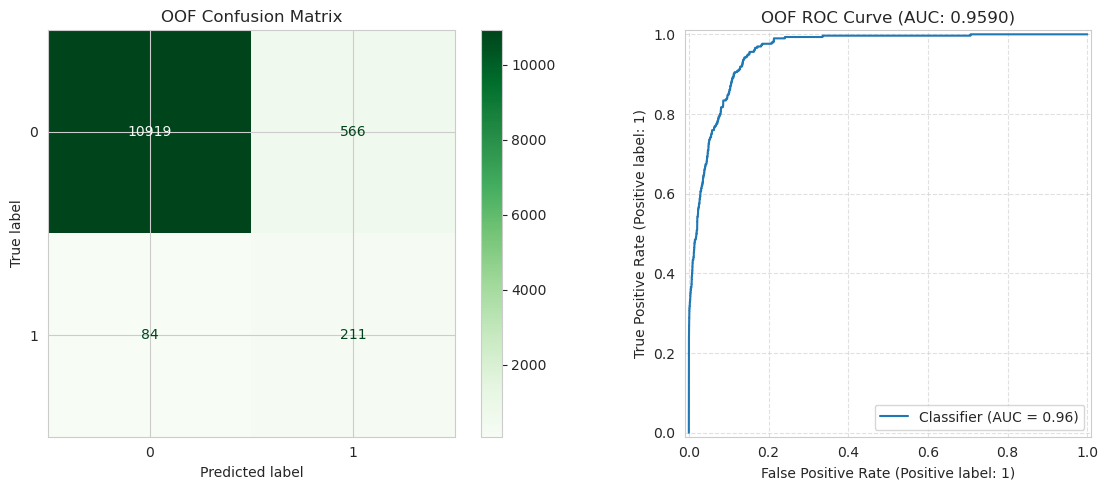

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay

# 1. Setup Stratified K-Fold
k_folds = 20
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Containers for results
oof_probs = np.zeros(len(X_train))  # Out-of-fold predictions
test_probs = np.zeros(len(X_test))   # Averaged test predictions
fold_metrics = []

print(f"Starting {k_folds}-Fold CV for Random Forest...\n")

# 2. Cross-Validation Loop
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    # Split data based on fold indices
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Initialize Random Forest
    # Note: No 'eval_set' or 'early_stopping' here as RF doesn't use them like XGBoost
    model = RandomForestClassifier(
        n_estimators=1000,
        max_depth=12,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    
    # Fit Model
    model.fit(X_fold_train, y_fold_train)
    
    # Predict probabilities
    fold_prob = model.predict_proba(X_fold_val)[:, 1]
    oof_probs[val_idx] = fold_prob
    
    # Aggregate test predictions (divide by k_folds to get the mean at the end)
    test_probs += model.predict_proba(X_test)[:, 1] / k_folds
    
    # Calculate Fold Metrics
    ll = log_loss(y_fold_val, fold_prob)
    auc = roc_auc_score(y_fold_val, fold_prob)
    fold_metrics.append((ll, auc))
    
    print(f"Fold {fold+1} | LogLoss: {ll:.5f} | AUC: {auc:.5f}")

# 3. Final Scoring
avg_ll = np.mean([m[0] for m in fold_metrics])
avg_auc = np.mean([m[1] for m in fold_metrics])

print(f"\n{'='*40}")
print(f"RF CV Overall LogLoss: {avg_ll:.5f}")
print(f"RF CV Overall AUC:     {avg_auc:.5f}")
print(f"{'='*40}")

# 4. Visualization (using OOF predictions)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Confusion Matrix (using 0.5 threshold on OOF probs)
oof_pred_labels = (oof_probs > 0.5).astype(int)
ConfusionMatrixDisplay.from_predictions(y_train, oof_pred_labels, ax=ax1, cmap='Greens')
ax1.set_title("OOF Confusion Matrix")

# ROC Curve
RocCurveDisplay.from_predictions(y_train, oof_probs, ax=ax2)
ax2.set_title(f"OOF ROC Curve (AUC: {avg_auc:.4f})")
ax2.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# Final Test Predictions
rf_test_pred_scaled = test_probs

Starting 20-Fold CV for Vanilla Random Forest...

Fold 1 | LogLoss: 0.05759 | AUC: 0.96609
Fold 2 | LogLoss: 0.05509 | AUC: 0.97006
Fold 3 | LogLoss: 0.04715 | AUC: 0.97217
Fold 4 | LogLoss: 0.03945 | AUC: 0.99106
Fold 5 | LogLoss: 0.04119 | AUC: 0.98547
Fold 6 | LogLoss: 0.06555 | AUC: 0.97062
Fold 7 | LogLoss: 0.05349 | AUC: 0.97236
Fold 8 | LogLoss: 0.06340 | AUC: 0.96597
Fold 9 | LogLoss: 0.06716 | AUC: 0.95575
Fold 10 | LogLoss: 0.04887 | AUC: 0.98130
Fold 11 | LogLoss: 0.06020 | AUC: 0.96783
Fold 12 | LogLoss: 0.05541 | AUC: 0.97962
Fold 13 | LogLoss: 0.05330 | AUC: 0.98548
Fold 14 | LogLoss: 0.05903 | AUC: 0.96585
Fold 15 | LogLoss: 0.06221 | AUC: 0.93728
Fold 16 | LogLoss: 0.06678 | AUC: 0.95116
Fold 17 | LogLoss: 0.04695 | AUC: 0.98026
Fold 18 | LogLoss: 0.05558 | AUC: 0.96841
Fold 19 | LogLoss: 0.05733 | AUC: 0.97364
Fold 20 | LogLoss: 0.06127 | AUC: 0.95563

Final CV LogLoss: 0.05585
Final CV AUC:     0.96980


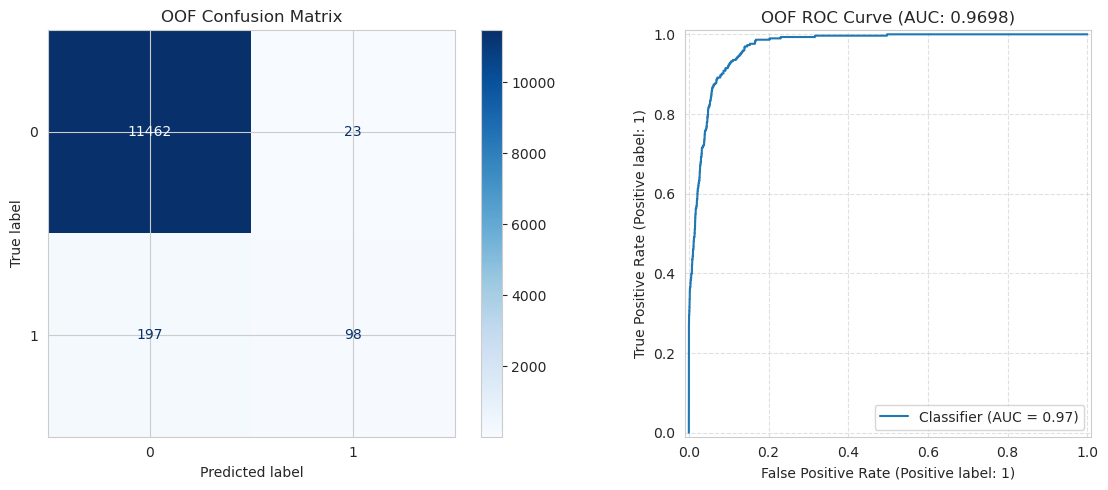

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay

# 1. Setup Stratified K-Fold
k_folds = 20
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Containers for results
oof_probs = np.zeros(len(X_train))  # Out-of-fold predictions for the training set
test_probs = np.zeros(len(X_test))   # Cumulative test predictions
fold_metrics = []

print(f"Starting {k_folds}-Fold CV for Vanilla Random Forest...\n")

# 2. Cross-Validation Loop
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    # Data splitting
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Initialize Model
    model = RandomForestClassifier(
        n_estimators=1000,
        max_depth=12,
        # class_weight='balanced', # Kept commented out per your snippet
        random_state=42,
        n_jobs=-1
    )
    
    # Fit Model
    model.fit(X_fold_train, y_fold_train)
    
    # Predict probabilities for the hold-out fold
    fold_prob = model.predict_proba(X_fold_val)[:, 1]
    oof_probs[val_idx] = fold_prob
    
    # Add to test set predictions (to be averaged later)
    test_probs += model.predict_proba(X_test)[:, 1] / k_folds
    
    # Calculate metrics for the current fold
    ll = log_loss(y_fold_val, fold_prob)
    auc = roc_auc_score(y_fold_val, fold_prob)
    fold_metrics.append((ll, auc))
    
    print(f"Fold {fold+1} | LogLoss: {ll:.5f} | AUC: {auc:.5f}")

# 3. Final Scoring
avg_ll = np.mean([m[0] for m in fold_metrics])
avg_auc = np.mean([m[1] for m in fold_metrics])

print(f"\n{'='*40}")
print(f"Final CV LogLoss: {avg_ll:.5f}")
print(f"Final CV AUC:     {avg_auc:.5f}")
print(f"{'='*40}")

# 4. Visualization (using OOF predictions)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# OOF Confusion Matrix
oof_pred_labels = (oof_probs > 0.5).astype(int)
ConfusionMatrixDisplay.from_predictions(y_train, oof_pred_labels, ax=ax1, cmap='Blues')
ax1.set_title("OOF Confusion Matrix")

# OOF ROC Curve
RocCurveDisplay.from_predictions(y_train, oof_probs, ax=ax2)
ax2.set_title(f"OOF ROC Curve (AUC: {avg_auc:.4f})")
ax2.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# Final Test Predictions (Mean across all folds)
rf_test_pred = test_probs

In [85]:
best_pred = rf_test_pred_scaled  # replace with best model's test_pred
submission = pd.DataFrame({
    'ID': test_ids,
    'Target_AUC': best_pred,
    'Target_LogLoss': best_pred
})
submission.to_csv('regex_rf_balanced_20cv.csv', index=False)

### 4.6 Vanilla Model's Comparison

In [ ]:
best_pred = xgb_test_pred  # replace with best model's test_pred
submission = pd.DataFrame({
    'ID': test_ids,
    'Target_AUC': best_pred,
    'Target_LogLoss': best_pred
})
submission.to_csv('xgb_auc_20cv.csv', index=False)

In [ ]:
test_df.shape

In [ ]:
submission.shape

In [ ]:
submission.head(10)

## 5 Submission Comparisons

In [86]:
xgb_balanced_logloss = pd.read_csv('regex_xgb_balanced_logloss_20cv.csv')
xgb_logloss = pd.read_csv('regex_xgb_logloss_20cv.csv')
xgb_balanced_auc = pd.read_csv('regex_xgb_balanced_auc_20cv.csv')
xgb_auc = pd.read_csv('regex_xgb_auc_20cv.csv')
rf_balanced = pd.read_csv('regex_rf_balanced_20cv.csv')
rf = pd.read_csv('regex_rf_20cv.csv')

In [87]:
nltk_xgb_balanced_logloss = pd.read_csv('nltk_xgb_balanced_logloss_20cv.csv')
nltk_xgb_logloss = pd.read_csv('nltk_xgb_logloss_20cv.csv')
nltk_xgb_balanced_auc = pd.read_csv('nltk_xgb_balanced_auc_20cv.csv')
nltk_xgb_auc = pd.read_csv('nltk_xgb_auc_20cv.csv')
nltk_rf_balanced = pd.read_csv('nltk_rf_balanced_20cv.csv')
nltk_rf = pd.read_csv('nltk_rf_20cv.csv')
nltk_cb_balanced = pd.read_csv('nltk_cb_balanced_20cv.csv')
nltk_cb = pd.read_csv('nltk_cb_20cv.csv')

# 6 Ensembles

In [90]:
# List of all 16 CSV file paths
file_paths = [
    'nltk_xgb_balanced_logloss_20cv.csv',
    'nltk_xgb_logloss_20cv.csv',
    'nltk_xgb_balanced_auc_20cv.csv',
    'nltk_xgb_auc_20cv.csv',
    'nltk_rf_balanced_20cv.csv',
    'nltk_rf_20cv.csv',
    'nltk_cb_balanced_20cv.csv',
    'nltk_cb_20cv.csv',
    'regex_xgb_balanced_logloss_20cv.csv',
    'regex_xgb_logloss_20cv.csv',
    'regex_xgb_balanced_auc_20cv.csv',
    'regex_xgb_auc_20cv.csv',
    'regex_rf_balanced_20cv.csv',
    'regex_rf_20cv.csv'
]

# Read all files, sort by ID to ensure alignment, and reset index
dfs = [pd.read_csv(fp).sort_values('ID').reset_index(drop=True) for fp in file_paths]

# Verify all DataFrames have identical IDs (critical safety check)
assert all((dfs[0]['ID'] == df['ID']).all() for df in dfs[1:]), "ID mismatch detected across files!"

# Stack target columns into 2D arrays (shape: [n_samples, 14])
auc_values = np.column_stack([df['Target_AUC'].values for df in dfs])
logloss_values = np.column_stack([df['Target_LogLoss'].values for df in dfs])

# Compute ensemble averages
ensemble = pd.DataFrame({
    'ID': dfs[0]['ID'],
    'Target_AUC': auc_values.mean(axis=1),
    'Target_LogLoss': logloss_values.mean(axis=1)
})

# Save the ensembled result
ensemble.to_csv('ensembles/vanilla_models_average.csv', index=False)

print(f"Ensemble completed successfully! Averaged {len(dfs)} models.")
print(f"Output shape: {ensemble.shape}")
print(f"Target_AUC range: [{ensemble['Target_AUC'].min():.4f}, {ensemble['Target_AUC'].max():.4f}]")
print(f"Target_LogLoss range: [{ensemble['Target_LogLoss'].min():.4f}, {ensemble['Target_LogLoss'].max():.4f}]")

Ensemble completed successfully! Averaged 14 models.
Output shape: (5055, 3)
Target_AUC range: [0.0087, 0.9637]
Target_LogLoss range: [0.0087, 0.9637]


In [91]:
train_nltk = pd.read_csv('train_preprocessed.csv')
test_nltk = pd.read_csv('test_preprocessed.csv')

In [92]:
train_nltk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11780 entries, 0 to 11779
Columns: 417 entries, ID to county_Uasin Gishu
dtypes: bool(9), float64(6), int64(397), object(5)
memory usage: 36.8+ MB


In [93]:
test_nltk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5055 entries, 0 to 5054
Columns: 416 entries, ID to county_Uasin Gishu
dtypes: bool(9), float64(6), int64(396), object(5)
memory usage: 15.7+ MB


## References
1. Nargesian, F., Samulowitz, H., Khurana, U., Khalil, E. B., & Turaga, D. S. (2017, August). Learning feature engineering for classification. In Ijcai (Vol. 17, pp. 2529-2535). https://www.ijcai.org/Proceedings/2017/0352.pdf
2. Xiao, Y., Huang, J., Weng, W., Huang, R., Shao, Q., Zhou, C., & Li, S. (2024). Class imbalance: A crucial factor affecting the performance of tea plantations mapping by machine learning. International Journal of Applied Earth Observation and Geoinformation, 129, 103849. https://doi.org/10.1016/j.jag.2024.103849
3. Zhou, L., Pan, S., Wang, J., & Vasilakos, A. V. (2017). Machine learning on big data: Opportunities and challenges. Neurocomputing, 237, 350-361.https://doi.org/10.1016/j.neucom.2017.01.026